--- Plotting Slide 1: Mergeability ---


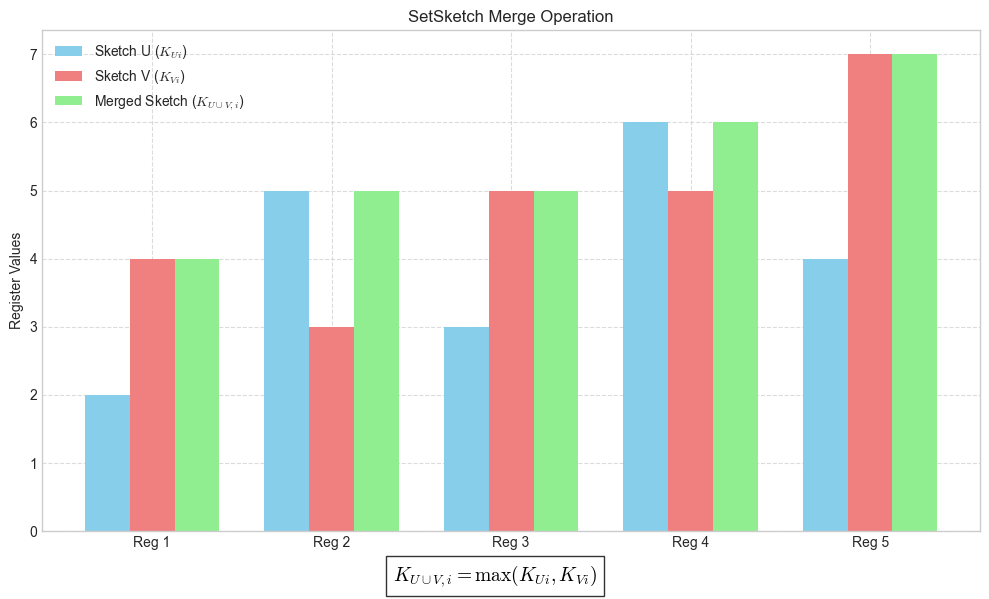


--- Plotting Slide 2: Distributions (Equations Removed) ---


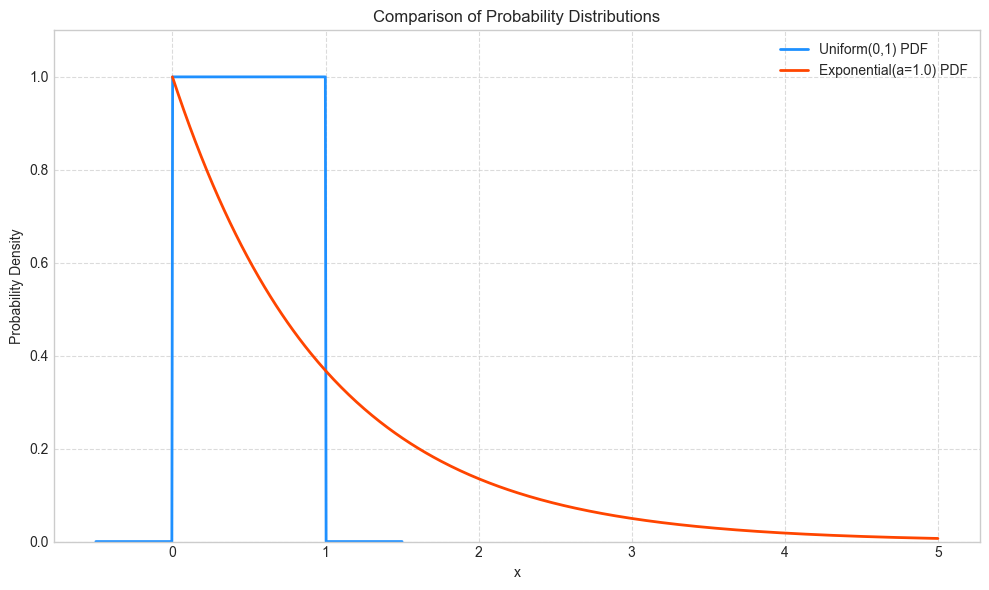


--- Plotting Slide 3: Definition & Algorithm 1 Conceptual ---


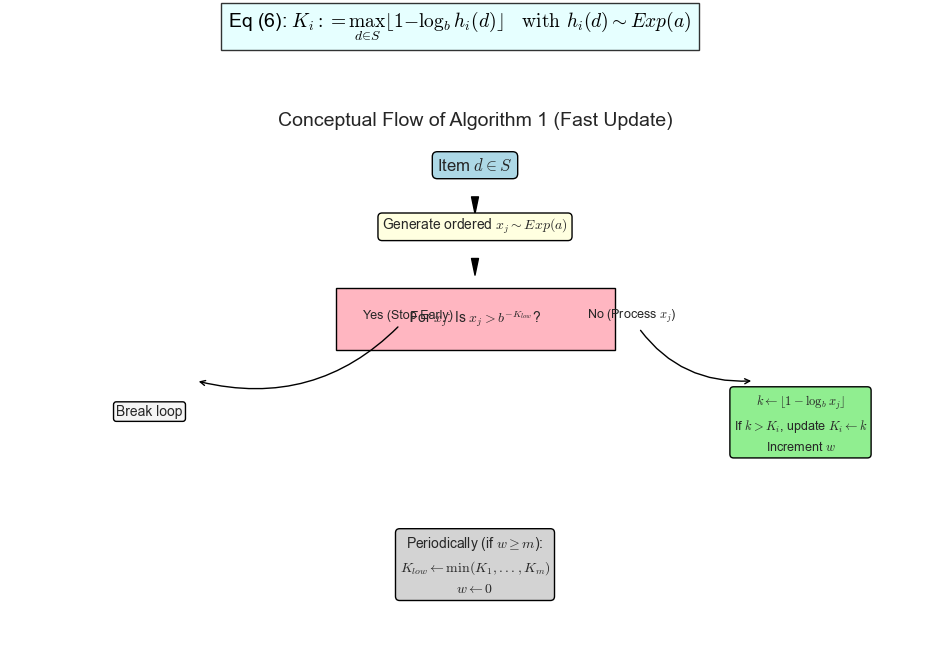


--- Plotting Slide 4: Hashing Conceptual ---


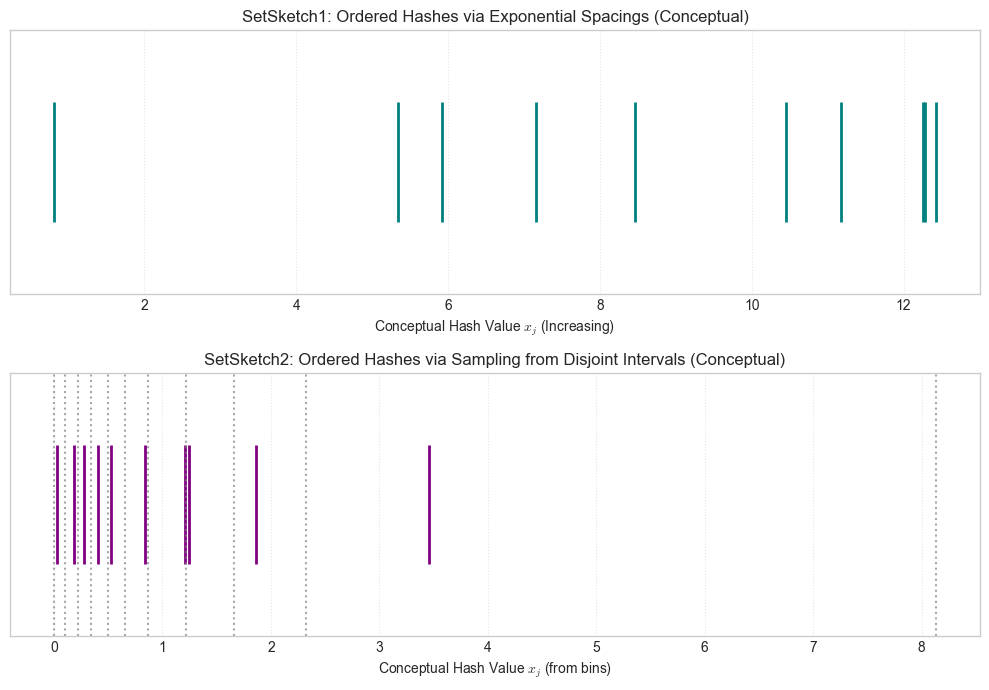

Note for Slide 4: The parameter table (m, b, a, q) should be added as text directly on your presentation slide.

--- Plotting Slide 5: Cardinality RSD (Equation Removed) ---


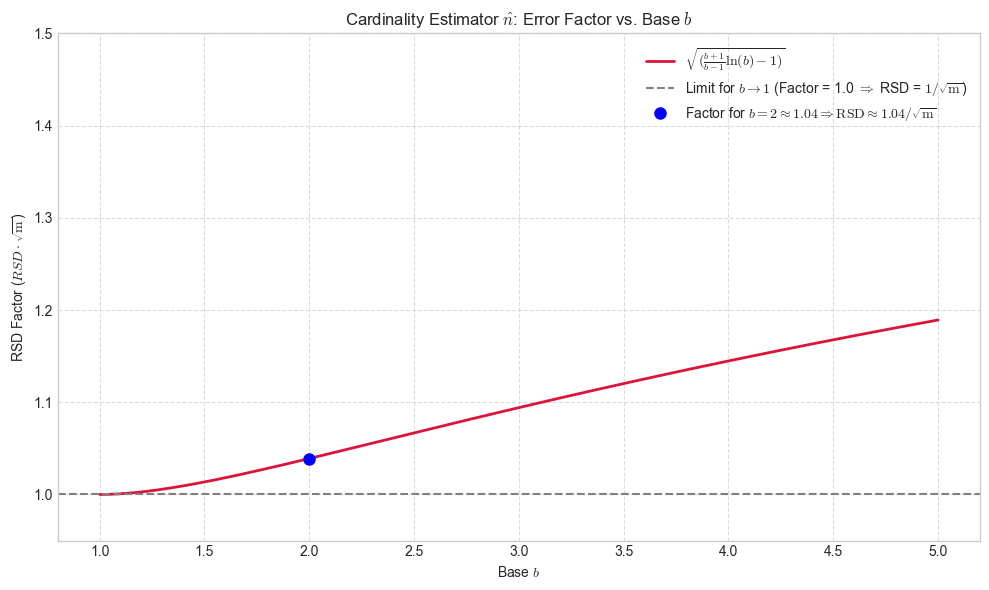


--- Plotting Slide 6: Joint Estimation Diagram (Improved) ---


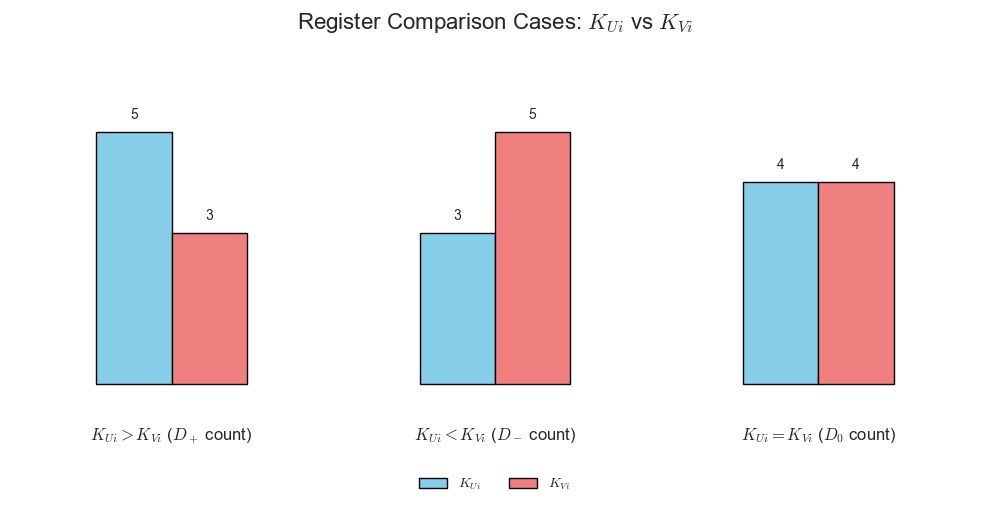


--- Plotting Slide 7: Figure 2 Replication & Log-Likelihood ---


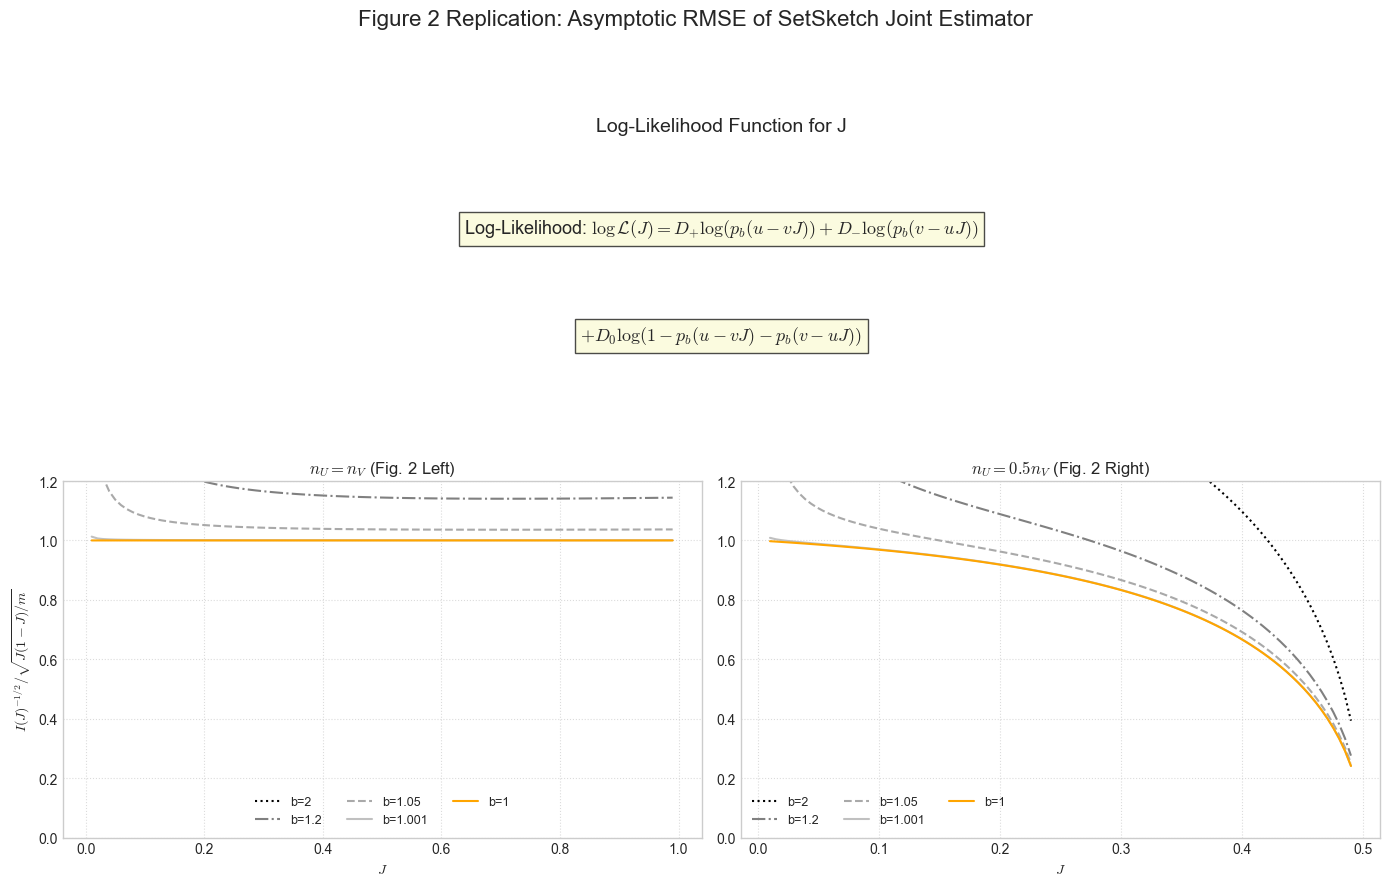


--- Plotting Slide 8: Figure 3 Replication (LSH Collision Probability) ---


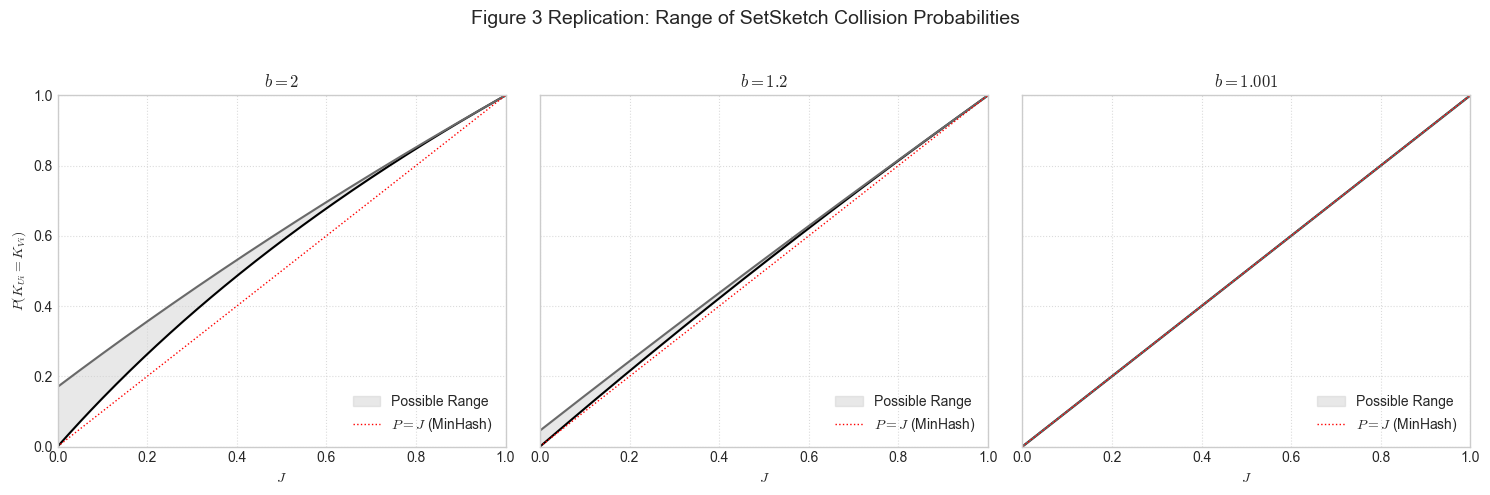


--- Plotting Slide 9: Figure 4 Replication & Equation 15 ---


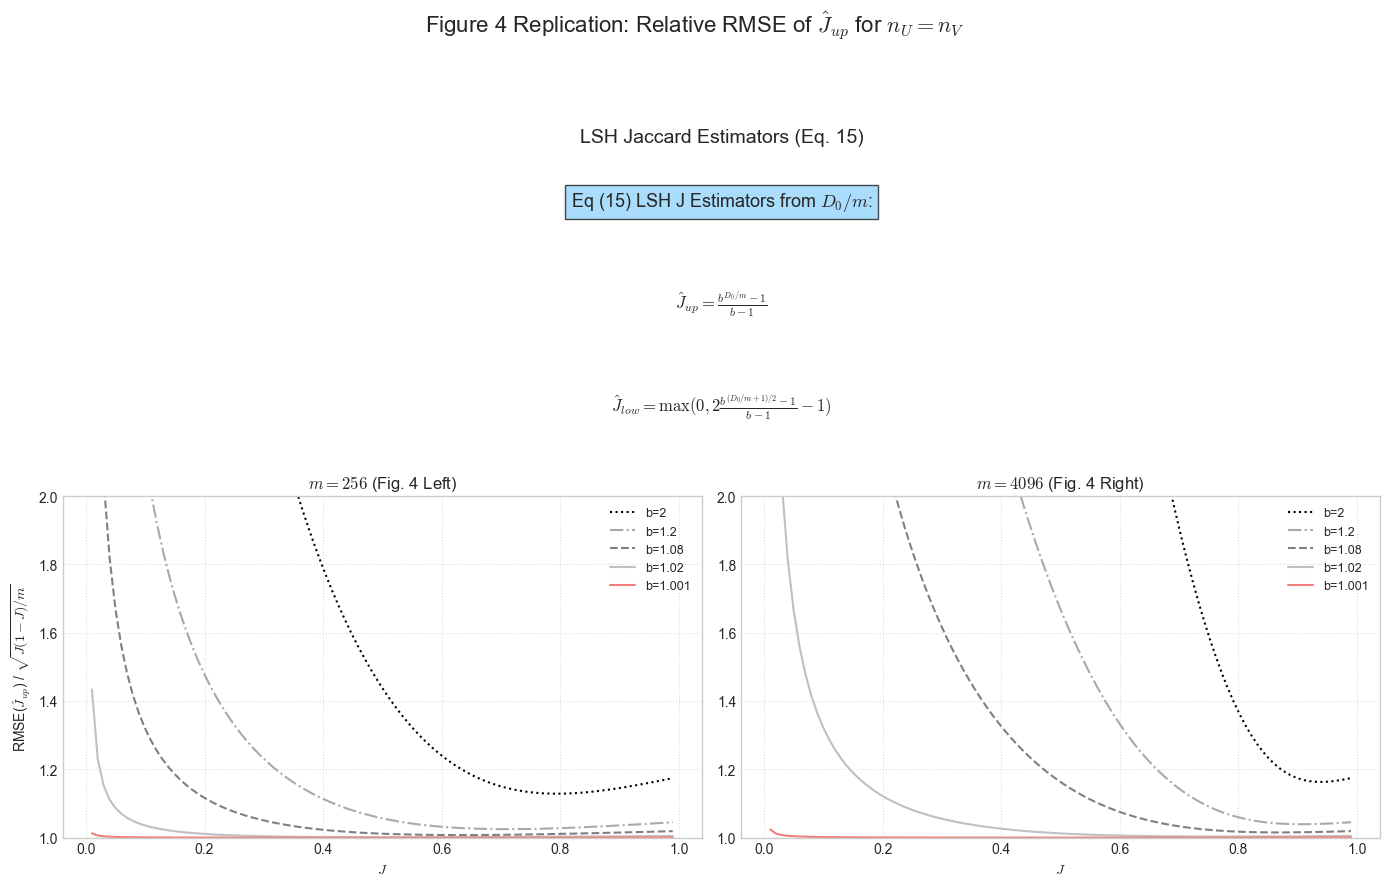

Note for Slide 9: Add the summary bullet point textually to your slide.
--- Plotting Slide 10: SetSketch vs. MinHash ---


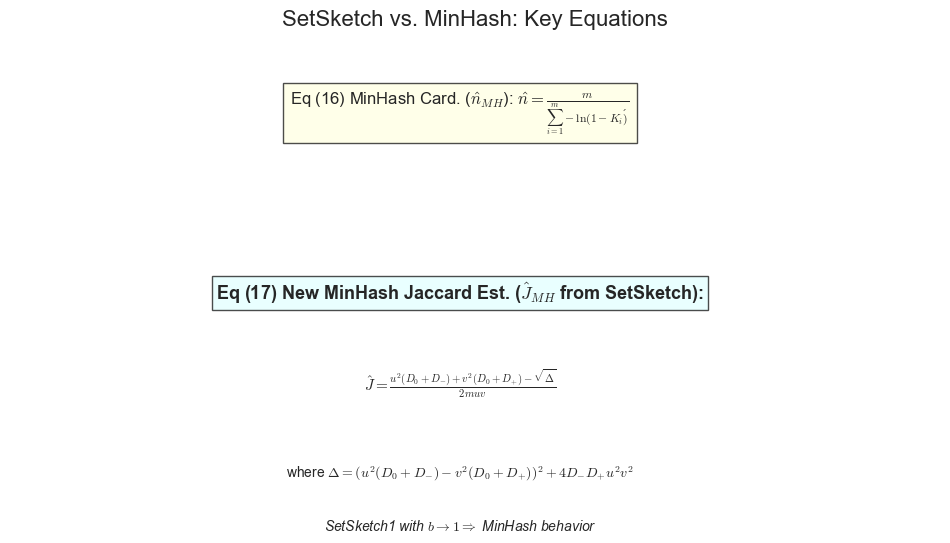


--- Plotting Slide 11: SetSketch vs. HLL/GHLL ---


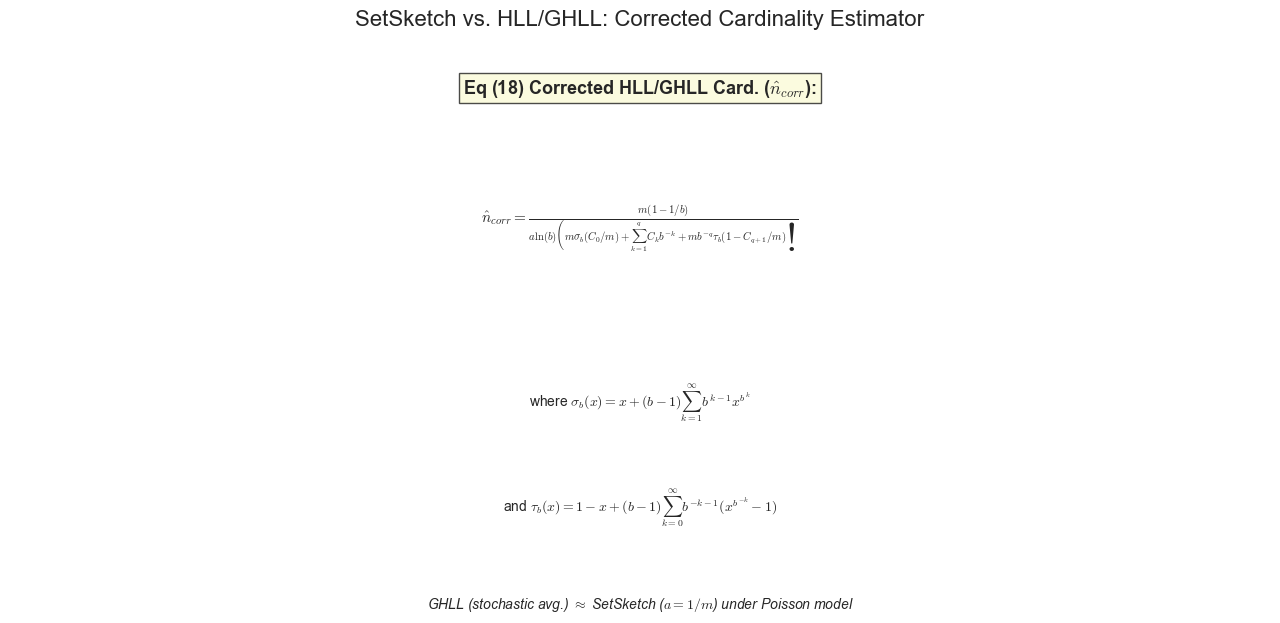


--- Plotting Slide 12: Broader Applications ---


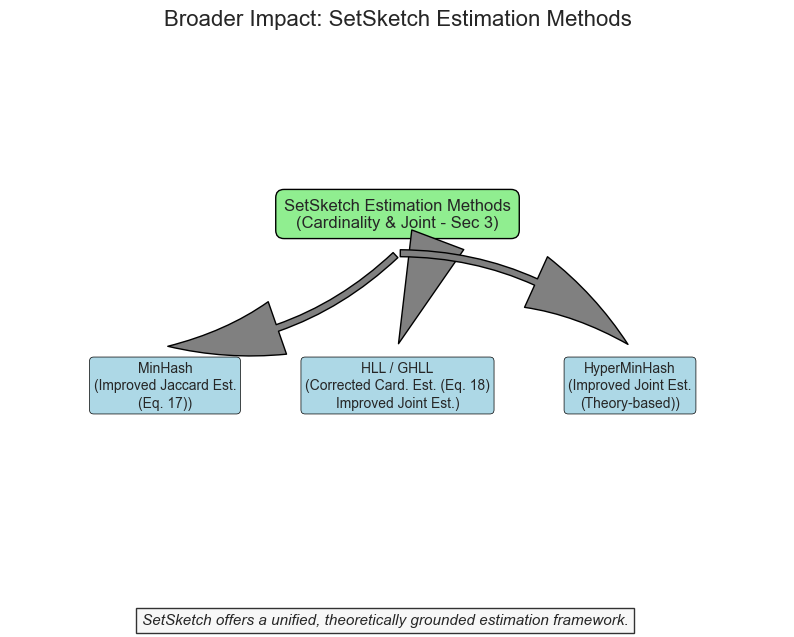

--- Plotting Slide 14: Cardinality Estimation (Mock Fig 5) ---


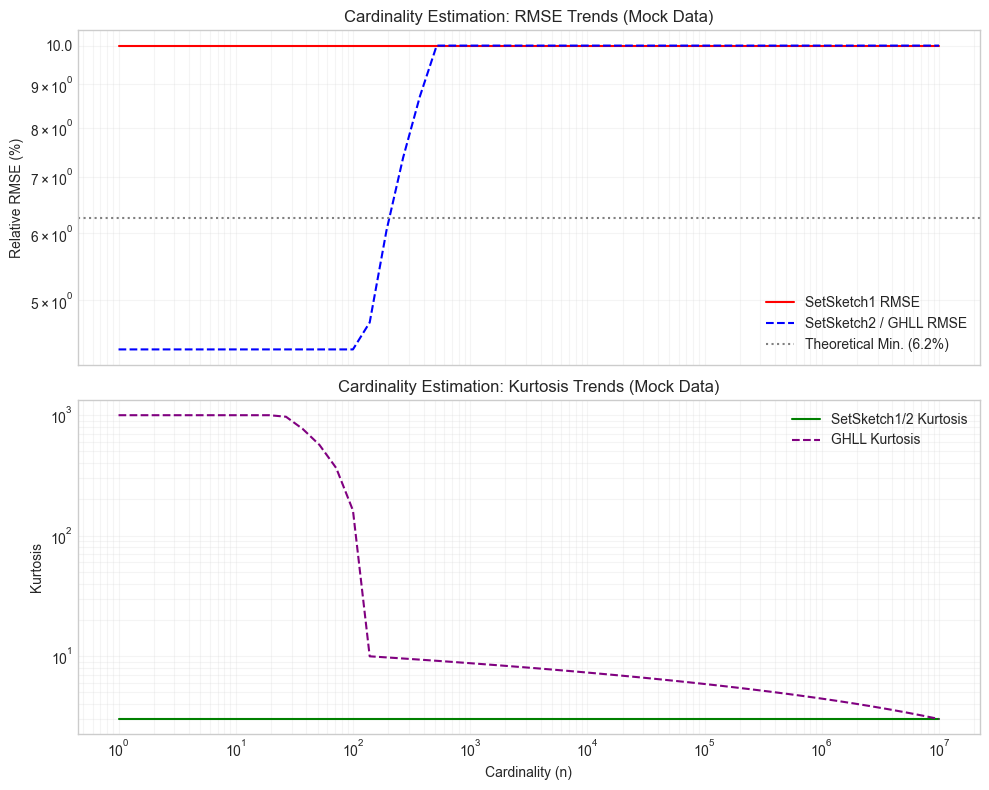


--- Plotting Slide 15: Joint Estimation - SetSketch (Mock Fig 6/7) ---


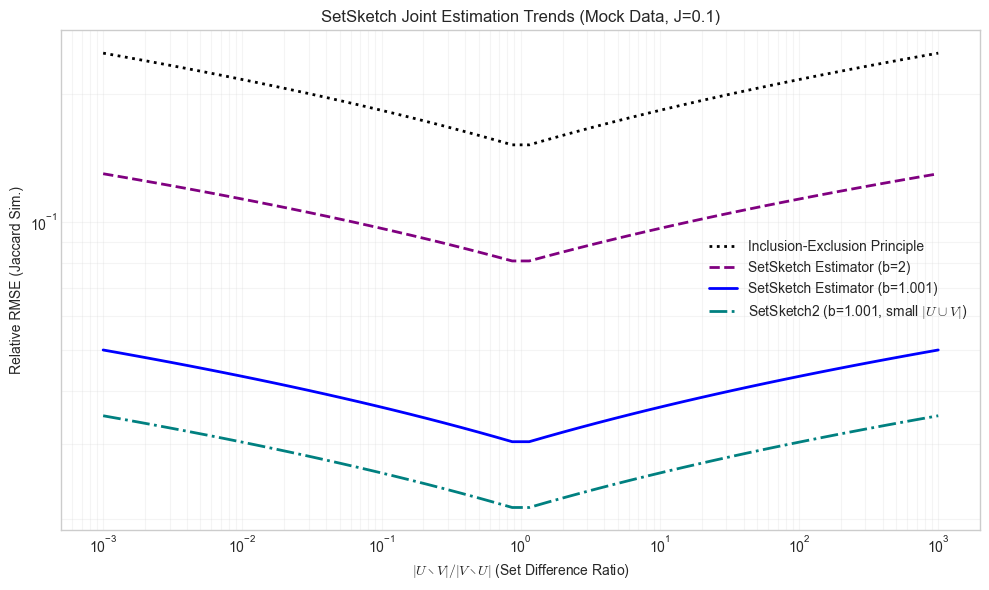


--- Plotting Slide 16: Joint Estimation - MinHash (Mock Fig 8) ---


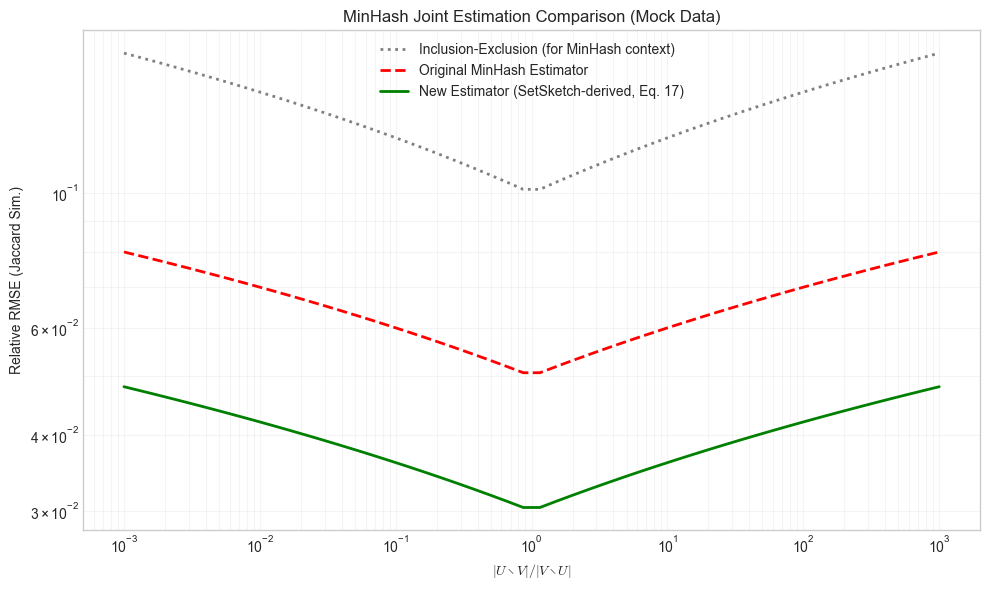


--- Plotting Slide 17: Joint Estimation - HyperMinHash (Mock Fig 9) ---


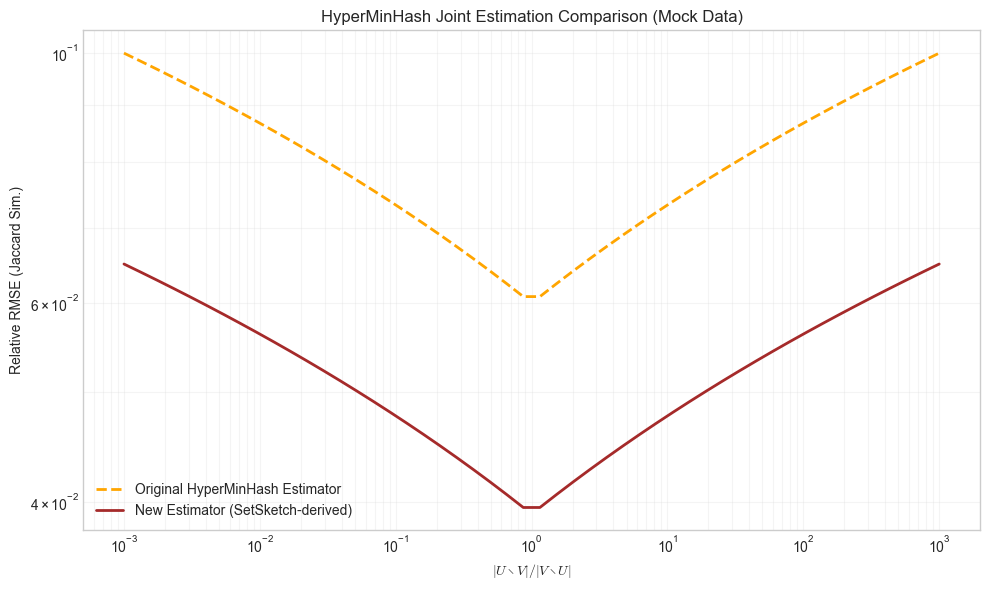


--- Plotting Slide 18: Recording Time Performance (Mock Fig 10) ---


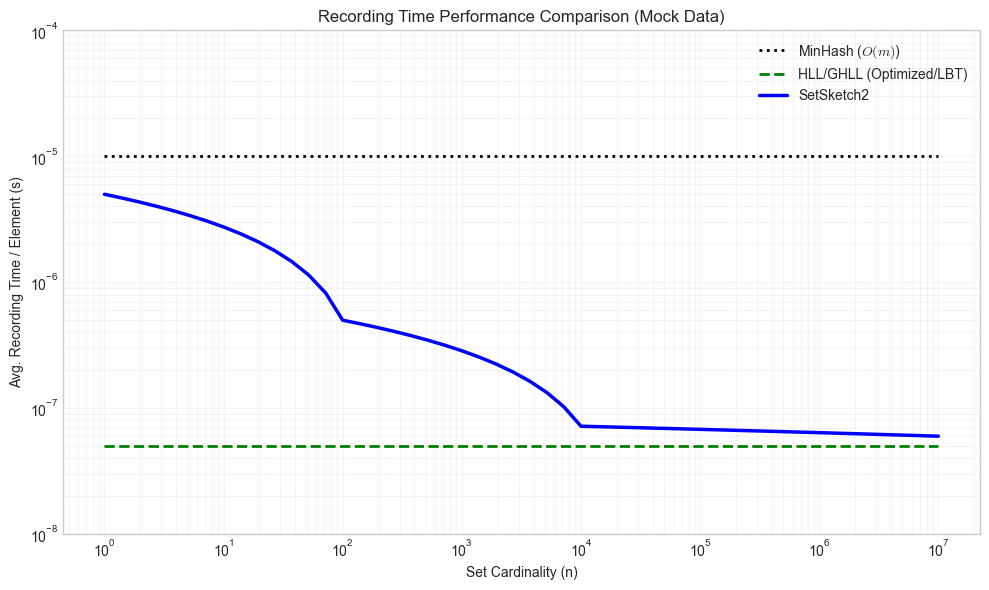

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker # <<< IMPORT ADDED HERE

# Common styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['text.usetex'] = False # Fallback if LaTeX is not installed, then use mathtext
plt.rcParams['mathtext.fontset'] = 'cm' # Use Computer Modern for math text

# --- Slide 1: Mergeability Illustration ---
# (Assumed correct from previous versions, not shown again for brevity unless needed)
def plot_slide1_mergeability():
    labels = ['Reg 1', 'Reg 2', 'Reg 3', 'Reg 4', 'Reg 5']
    k_u = [2, 5, 3, 6, 4]
    k_v = [4, 3, 5, 5, 7]
    k_merged = [max(u, v) for u, v in zip(k_u, k_v)]
    x = np.arange(len(labels))
    width = 0.25
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, k_u, width, label='Sketch U ($K_{Ui}$)', color='skyblue')
    rects2 = ax.bar(x, k_v, width, label='Sketch V ($K_{Vi}$)', color='lightcoral')
    rects3 = ax.bar(x + width, k_merged, width, label='Merged Sketch ($K_{U \\cup V,i}$)', color='lightgreen')
    ax.set_ylabel('Register Values')
    ax.set_title('SetSketch Merge Operation')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    eq_text = r'$K_{U \cup V, i} = \max(K_{Ui}, K_{Vi})$'
    fig.text(0.5, 0.01, eq_text, ha='center', va='bottom', fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8, pad=5))
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

# --- Slide 2: Exponential vs. Uniform Distribution & Equations ---
# (Corrected in previous response, assumed correct here)
def plot_slide2_distributions_only():
    """
    Plots PDF of Exponential distribution vs. Uniform(0,1) distribution.
    Equations removed as per request.
    """
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figsize if needed

    # Plotting distributions
    x_uniform = np.linspace(-0.5, 1.5, 400)
    pdf_uniform = np.where((x_uniform >= 0) & (x_uniform <= 1), 1, 0)
    a_exp = 1.0 # Rate parameter for exponential
    x_exp = np.linspace(0, 5, 400)
    pdf_exp = a_exp * np.exp(-a_exp * x_exp)

    ax.plot(x_uniform, pdf_uniform, label='Uniform(0,1) PDF', color='dodgerblue', lw=2)
    ax.plot(x_exp, pdf_exp, label=f'Exponential(a={a_exp}) PDF', color='orangered', lw=2)
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_title('Comparison of Probability Distributions') # Updated title
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, max(np.max(pdf_uniform), np.max(pdf_exp)) * 1.1)

    fig.tight_layout()
    plt.show()

# --- Slide 3: SetSketch Definition & Algorithm 1 Conceptual Diagram (Corrected) ---
def plot_slide3_definition_and_algo1_conceptual():
    """
    Displays Equation 6 and a corrected conceptual diagram for Algorithm 1.
    Corrected \ge to \geq
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off') 

    eq6_text = r'Eq (6): $K_i := \max_{d \in S} \lfloor 1 - \log_b h_i(d) \rfloor \quad \text{with } h_i(d) \sim Exp(a)$'
    fig.text(0.5, 0.92, eq6_text, ha='center', va='top', fontsize=14, color='black', bbox=dict(facecolor='lightcyan', alpha=0.8, pad=5))

    y_start = 0.8
    box_width = 0.3
    box_height = 0.1 
    arrow_props = dict(facecolor='black', shrink=0.05, width=1, headwidth=5)

    ax.text(0.5, y_start, "Item $d \in S$", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="lightblue"))
    
    ax.annotate("", xy=(0.5, y_start - 0.05 - box_height/2 + 0.02), xytext=(0.5, y_start - 0.05), arrowprops=arrow_props)
    ax.text(0.5, y_start - 0.1, "Generate ordered $x_j \sim Exp(a)$", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow"))

    ax.annotate("", xy=(0.5, y_start - 0.15 - box_height/2 + 0.02), xytext=(0.5, y_start - 0.15), arrowprops=arrow_props)
    ax.add_patch(patches.Rectangle((0.5 - box_width/2, y_start - 0.25 - box_height/2), box_width, box_height, facecolor='lightpink', edgecolor='black'))
    ax.text(0.5, y_start - 0.25, "For $x_j$: Is $x_j > b^{-K_{low}}$?", ha='center', va='center', fontsize=10)

    ax.annotate("Yes (Stop Early)", xy=(0.2, y_start - 0.35), xytext=(0.5 - box_width/2 * 0.8, y_start - 0.25), 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.3", facecolor='black'), fontsize=9)
    ax.text(0.15, y_start - 0.4, "Break loop", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.2", fc="whitesmoke"))

    ax.annotate("No (Process $x_j$)", xy=(0.8, y_start - 0.35), xytext=(0.5 + box_width/2 * 0.8, y_start - 0.25), 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", facecolor='black'), fontsize=9)
    
    line1 = r"$k \leftarrow \lfloor 1 - \log_b x_j \rfloor$"
    line2 = r"If $k > K_i$, update $K_i \leftarrow k$" 
    line3 = r"Increment $w$"
    full_text = line1 + "\n" + line2 + "\n" + line3
    ax.text(0.85, y_start - 0.42, full_text,
             ha='center', va='center', fontsize=9, linespacing=1.5,
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen"))

    # Corrected \ge to \geq in the text below
    k_low_update_text = ("Periodically (if $w \geq m$):\n" # Corrected here
                         "$K_{low} \leftarrow \min(K_1, ..., K_m)$\n"
                         "$w \leftarrow 0$")
    ax.text(0.5, y_start - 0.65, k_low_update_text, 
             ha='center', va='center', fontsize=10, linespacing=1.5,
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgray"))
    
    ax.set_title("Conceptual Flow of Algorithm 1 (Fast Update)", fontsize=14, y=0.85)
    plt.show()


# --- Slide 4: SetSketch1 vs SetSketch2 Hashing (Conceptual) & Parameter Table (Textual) ---
# (Assumed correct from previous versions)
def plot_slide4_hashing_conceptual_only():
    m = 10 
    spacings = np.random.exponential(scale=1.0, size=m) 
    x1_values = np.cumsum(spacings)
    exp_samples_for_bins = np.random.exponential(scale=1.0, size=1000)
    bin_edges = np.percentile(exp_samples_for_bins, np.linspace(0, 100, m + 1))
    x2_values = []
    for i in range(m):
        low_edge = bin_edges[i]
        high_edge = bin_edges[i+1]
        if high_edge <= low_edge: 
            high_edge = low_edge + 0.1 
        x2_values.append(np.random.uniform(low_edge, high_edge))
    x2_values = np.array(sorted(x2_values))
    fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
    axs[0].eventplot(x1_values, orientation='horizontal', colors='teal', lineoffsets=0.5, linelengths=0.8, linewidths=2)
    axs[0].set_yticks([])
    axs[0].set_title('SetSketch1: Ordered Hashes via Exponential Spacings (Conceptual)')
    axs[0].set_xlabel('Conceptual Hash Value $x_j$ (Increasing)')
    axs[0].grid(True, linestyle=':', alpha=0.5)
    axs[1].eventplot(x2_values, orientation='horizontal', colors='purple', lineoffsets=0.5, linelengths=0.8, linewidths=2)
    for edge in bin_edges: 
        axs[1].axvline(edge, color='gray', linestyle=':', alpha=0.7)
    axs[1].set_yticks([])
    axs[1].set_title('SetSketch2: Ordered Hashes via Sampling from Disjoint Intervals (Conceptual)')
    axs[1].set_xlabel('Conceptual Hash Value $x_j$ (from bins)')
    axs[1].grid(True, linestyle=':', alpha=0.5)
    fig.tight_layout()
    plt.show()
    print("Note for Slide 4: The parameter table (m, b, a, q) should be added as text directly on your presentation slide.")

# --- Slide 5: Cardinality Estimation RSD & Equation (Corrected) ---
def plot_slide5_cardinality_rsd_only():
    """
    Plots Relative Standard Deviation (RSD) for cardinality estimation.
    Equation 12 removed as per request.
    """
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figsize if needed
    
    b_values = np.linspace(1.0001, 5, 500) 
    term = (b_values + 1) / (b_values - 1) * np.log(b_values) - 1
    term = np.maximum(term, 0) 
    rsd_factor = np.sqrt(term) 

    ax.plot(b_values, rsd_factor, label=r'$\sqrt{(\frac{b+1}{b-1}\ln(b)-1)}$', color='crimson', lw=2)
    
    label_b_to_1 = r'Limit for $b \to 1$ (Factor = 1.0 $\Rightarrow$ RSD = $1/\sqrt{\mathrm{m}}$)'
    ax.axhline(1.0, color='gray', linestyle='--', label=label_b_to_1)
    
    rsd_b2_factor = np.sqrt(((2+1)/(2-1)) * np.log(2) - 1)
    label_b_eq_2_template = 'Factor for $b=2 \\approx {:.2f} \\Rightarrow \\mathrm{{RSD}} \\approx 1.04/\\sqrt{{\mathrm{{m}}}}$'
    label_b_eq_2 = label_b_eq_2_template.format(rsd_b2_factor)
    ax.plot(2, rsd_b2_factor, 'o', color='blue', markersize=8, label=label_b_eq_2)
    
    ax.set_xlabel('Base $b$')
    ax.set_ylabel('RSD Factor ($RSD \cdot \sqrt{\mathrm{m}}$)')
    ax.set_title('Cardinality Estimator $\hat{n}$: Error Factor vs. Base $b$')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0.95, 1.5)
    
    fig.tight_layout() # Standard tight_layout
    plt.show()

# --- Slide 6: Joint Estimation - Baseline, Probabilities & Diagram ---
# (Assumed correct from previous versions)
def plot_slide6_joint_estimation_diagram_improved():
    """
    Displays an improved diagram for register comparison cases ($K_{Ui}$ vs $K_{Vi}$).
    Equations removed as per request.
    """
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figsize for better spacing
    
    ax.axis('off') # Turn off axis for a cleaner diagram
    ax.set_title("Register Comparison Cases: $K_{Ui}$ vs $K_{Vi}$", fontsize=16, pad=20)

    bar_height_KUi = [5, 3, 4]
    bar_height_KVi = [3, 5, 4]
    case_labels = ["$K_{Ui} > K_{Vi}$ ($D_+$ count)", 
                   "$K_{Ui} < K_{Vi}$ ($D_-$ count)", 
                   "$K_{Ui} = K_{Vi}$ ($D_0$ count)"]
    
    num_cases = len(case_labels)
    bar_width = 0.35
    group_spacing = 1.5 # Increased spacing between groups
    
    x_positions_group_center = np.arange(num_cases) * group_spacing
    
    for i in range(num_cases):
        center = x_positions_group_center[i]
        # Bar for K_Ui
        ax.bar(center - bar_width/2, bar_height_KUi[i], bar_width, 
               color='skyblue', edgecolor='black', label='$K_{Ui}$' if i == 0 else "")
        ax.text(center - bar_width/2, bar_height_KUi[i] + 0.2, f'{bar_height_KUi[i]}', 
                ha='center', va='bottom', fontsize=10)
        
        # Bar for K_Vi
        ax.bar(center + bar_width/2, bar_height_KVi[i], bar_width, 
               color='lightcoral', edgecolor='black', label='$K_{Vi}$' if i == 0 else "")
        ax.text(center + bar_width/2, bar_height_KVi[i] + 0.2, f'{bar_height_KVi[i]}', 
                ha='center', va='bottom', fontsize=10)
        
        # Case label below bars
        ax.text(center, -0.8, case_labels[i], ha='center', va='top', fontsize=12)

    ax.set_ylim(-1.5, max(max(bar_height_KUi), max(bar_height_KVi)) + 1.5) # Adjust y-limits
    ax.set_xlim(x_positions_group_center[0] - group_spacing/2, 
                x_positions_group_center[-1] + group_spacing/2)

    # Add a single legend
    handles, labels = ax.get_legend_handles_labels()
    if handles: # Check if legend items exist
      fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.05))

    fig.tight_layout(rect=[0, 0.1, 1, 0.9]) # Adjust layout to make space for title and legend
    plt.show()

# --- Slide 7: Joint Estimation Accuracy (Figure 2 from paper) & Log-Likelihood ---
def plot_slide7_figure2_and_loglikelihood():
    """
    Replicates Figure 2 from the SetSketch paper.
    Displays the Log-Likelihood function textually.
    """
    # Helper function p_b(x) and its derivative p_b_prime(x)
    def p_b(x, b_val):
        if b_val == 1: return x
        arg = 1 - x * (b_val - 1) / b_val
        if isinstance(arg, np.ndarray): arg[arg <= 1e-9] = 1e-9
        elif arg <= 1e-9: arg = 1e-9
        return -np.log(arg) / np.log(b_val)

    def p_b_prime(x, b_val):
        if b_val == 1: return 1.0
        denominator_arg = 1 - x * (b_val - 1) / b_val
        if isinstance(denominator_arg, np.ndarray): denominator_arg[denominator_arg <= 1e-9] = 1e-9
        elif denominator_arg <= 1e-9: denominator_arg = 1e-9
        val_b_pow_pb = 1.0 / denominator_arg
        return (b_val - 1) / (b_val * np.log(b_val)) * val_b_pow_pb

    def fisher_information(J_val, b_val, u, v, m_val=1):
        arg1 = u - v * J_val
        arg2 = v - u * J_val
        epsilon = 1e-9
        arg1 = np.clip(arg1, 0, 1-epsilon)
        arg2 = np.clip(arg2, 0, 1-epsilon)
        pb_arg1 = p_b(arg1, b_val)
        pb_arg2 = p_b(arg2, b_val)
        pb_arg1_safe = np.where(pb_arg1 == 0, epsilon, pb_arg1)
        pb_arg2_safe = np.where(pb_arg2 == 0, epsilon, pb_arg2)
        pb_prime_arg1 = p_b_prime(arg1, b_val)
        pb_prime_arg2 = p_b_prime(arg2, b_val)
        term1_num = (v * pb_prime_arg1)**2
        term1 = term1_num / pb_arg1_safe
        term2_num = (u * pb_prime_arg2)**2
        term2 = term2_num / pb_arg2_safe
        pb0 = 1 - pb_arg1 - pb_arg2
        pb0_safe = np.where(pb0 <= epsilon, epsilon, pb0)
        term3_num = (v * pb_prime_arg1 + u * pb_prime_arg2)**2
        term3 = term3_num / pb0_safe
        factor = m_val * (b_val - 1)**2 / (b_val**2 * np.log(b_val)**2)
        I_J = factor * (term1 + term2 + term3)
        return I_J

    b_values_fig2 = [2, 1.2, 1.05, 1.001, 1.000001] 
    linestyles = [':', '-.', '--', '-', '-']
    colors = ['black', 'gray', 'darkgray', 'silver', 'orange'] 

    fig = plt.figure(figsize=(14, 9)) # Adjusted for equation
    gs = fig.add_gridspec(2, 2)
    ax_fig2_left = fig.add_subplot(gs[1, 0])
    ax_fig2_right = fig.add_subplot(gs[1, 1])
    ax_eq_logL = fig.add_subplot(gs[0, :])
    ax_eq_logL.axis('off')

    # Display Log-Likelihood Equation
    logL_text1 = r'Log-Likelihood: $\log \mathcal{L}(J) = D_{+} \log(p_b(u-vJ)) + D_{-} \log(p_b(v-uJ))$'
    logL_text2 = r'$+ D_{0} \log(1 - p_b(u-vJ) - p_b(v-uJ))$'
    ax_eq_logL.text(0.5, 0.6, logL_text1, ha='center', va='center', fontsize=13, bbox=dict(facecolor='lightgoldenrodyellow', alpha=0.7, pad=4))
    ax_eq_logL.text(0.5, 0.3, logL_text2, ha='center', va='center', fontsize=13, bbox=dict(facecolor='lightgoldenrodyellow', alpha=0.7, pad=4))
    ax_eq_logL.set_title("Log-Likelihood Function for J", fontsize=14, y=0.85)


    # Figure 2 - Case 1: n_U = n_V
    u1, v1 = 0.5, 0.5
    J_max1 = 1.0
    J_vals1 = np.linspace(0.01, J_max1 - 0.01, 100)
    for i, b_val in enumerate(b_values_fig2):
        I_J_vals = fisher_information(J_vals1, b_val, u1, v1)
        minhash_rmse_factor_sq = J_vals1 * (1 - J_vals1)
        minhash_rmse_factor_sq[minhash_rmse_factor_sq < 1e-9] = 1e-9
        ratio = 1.0 / np.sqrt(I_J_vals * minhash_rmse_factor_sq)
        ax_fig2_left.plot(J_vals1, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_left.set_title('$n_U = n_V$ (Fig. 2 Left)')
    ax_fig2_left.set_xlabel('$J$')
    ax_fig2_left.set_ylabel('$I(J)^{-1/2} / \sqrt{J(1-J)/m}$')
    ax_fig2_left.set_ylim(0, 1.2)
    ax_fig2_left.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_left.legend(loc='lower center', ncol=3, fontsize=9)

    # Figure 2 - Case 2: n_U = 0.5 * n_V
    u2, v2 = 1/3, 2/3
    J_max2 = 0.5 
    J_vals2 = np.linspace(0.01, J_max2 - 0.01, 100)
    for i, b_val in enumerate(b_values_fig2):
        I_J_vals = fisher_information(J_vals2, b_val, u2, v2)
        minhash_rmse_factor_sq = J_vals2 * (1 - J_vals2)
        minhash_rmse_factor_sq[minhash_rmse_factor_sq < 1e-9] = 1e-9
        ratio = 1.0 / np.sqrt(I_J_vals * minhash_rmse_factor_sq)
        ax_fig2_right.plot(J_vals2, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_right.set_title('$n_U = 0.5 n_V$ (Fig. 2 Right)')
    ax_fig2_right.set_xlabel('$J$')
    ax_fig2_right.set_ylim(0, 1.2)
    ax_fig2_right.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_right.legend(loc='lower left', ncol=3, fontsize=9)
    
    fig.suptitle("Figure 2 Replication: Asymptotic RMSE of SetSketch Joint Estimator", fontsize=16, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Slide 8: LSH Collision Probability (Figure 3 from paper) ---
def plot_slide8_figure3():
    """
    Replicates Figure 3 from the SetSketch paper.
    Range of possible collision probabilities P(K_Ui = K_Vi).
    """
    J_vals = np.linspace(0, 1, 200)
    b_values_fig3 = [2, 1.2, 1.001]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, b_val in enumerate(b_values_fig3):
        lower_bound_arg = 1 + J_vals * (b_val - 1)
        lower_bound_arg[lower_bound_arg <= 1e-9] = 1e-9 
        P_coll_lower = np.log(lower_bound_arg) / np.log(b_val)
        
        upper_bound_arg = 1 + J_vals * (b_val - 1) + ((1 - J_vals)**2 * (b_val - 1)**2) / (4 * b_val)
        upper_bound_arg[upper_bound_arg <= 1e-9] = 1e-9 
        P_coll_upper = np.log(upper_bound_arg) / np.log(b_val)

        axs[i].plot(J_vals, P_coll_lower, color='black', linestyle='-', lw=1.5)
        axs[i].plot(J_vals, P_coll_upper, color='dimgray', linestyle='-', lw=1.5) 
        axs[i].fill_between(J_vals, P_coll_lower, P_coll_upper, color='lightgray', alpha=0.5, label='Possible Range')
        axs[i].plot(J_vals, J_vals, color='red', linestyle=':', lw=1, label='$P=J$ (MinHash)')

        axs[i].set_title(f'$b = {b_val}$')
        axs[i].set_xlabel('$J$')
        if i == 0:
            axs[i].set_ylabel('$P(K_{Ui} = K_{Vi})$')
        axs[i].grid(True, linestyle=':', alpha=0.7)
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0, 1)
        axs[i].legend(loc='lower right')

    fig.suptitle("Figure 3 Replication: Range of SetSketch Collision Probabilities", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Slide 9: LSH RMSE (Figure 4 from paper) & Equation 15 ---
def plot_slide9_figure4_and_equation():
    """
    Replicates Figure 4 from the SetSketch paper.
    Displays Equation 15.
    """
    m_values = [256, 4096]
    b_values_fig4 = [2, 1.2, 1.08, 1.02, 1.001]
    linestyles = [':', '-.', '--', '-', '-'] 
    colors = ['black', 'darkgray', 'gray', 'silver', 'lightcoral'] 

    J_vals = np.linspace(0.01, 0.99, 100)

    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 2)
    ax_fig4_left = fig.add_subplot(gs[1, 0])
    ax_fig4_right = fig.add_subplot(gs[1, 1])
    ax_eq15 = fig.add_subplot(gs[0, :])
    ax_eq15.axis('off')

    # Display Equation 15
    eq15_text1 = r'Eq (15) LSH J Estimators from $D_0/m$:'
    eq15_text2 = r'$\hat{J}_{up} = \frac{b^{D_0/m}-1}{b-1}$'
    eq15_text3 = r'$\hat{J}_{low} = \max(0, 2\frac{b^{(D_0/m+1)/2}-1}{b-1}-1)$'
    ax_eq15.text(0.5, 0.75, eq15_text1, ha='center', va='center', fontsize=13, bbox=dict(facecolor='lightskyblue', alpha=0.7, pad=4))
    ax_eq15.text(0.5, 0.45, eq15_text2, ha='center', va='center', fontsize=12)
    ax_eq15.text(0.5, 0.15, eq15_text3, ha='center', va='center', fontsize=12)
    ax_eq15.set_title("LSH Jaccard Estimators (Eq. 15)", fontsize=14, y=0.9)


    for i, m_val in enumerate(m_values):
        ax = ax_fig4_left if i == 0 else ax_fig4_right
        for k, b_val in enumerate(b_values_fig4):
            arg_P_coll = 1 + J_vals*(b_val-1) + ((1-J_vals)**2 * (b_val-1)**2) / (4*b_val)
            arg_P_coll[arg_P_coll <= 1e-9] = 1e-9
            P_coll = np.log(arg_P_coll) / np.log(b_val)
            P_coll = np.clip(P_coll, 0, 1-1e-9)
            
            J_up_expected = (b_val**P_coll - 1) / (b_val - 1)
            derivative_J_up_at_P_coll = (b_val**P_coll * np.log(b_val)) / (b_val - 1)
            var_D0_m = P_coll * (1 - P_coll) / m_val
            var_J_up = (derivative_J_up_at_P_coll**2) * var_D0_m
            bias_J_up_sq = (J_up_expected - J_vals)**2 # Bias term
            rmse_J_up = np.sqrt(var_J_up + bias_J_up_sq)
            
            minhash_rmse = np.sqrt(J_vals * (1 - J_vals) / m_val)
            minhash_rmse[minhash_rmse < 1e-9] = 1e-9
            relative_rmse = rmse_J_up / minhash_rmse
            
            ax.plot(J_vals, relative_rmse, label=f'b={b_val}', linestyle=linestyles[k % len(linestyles)], color=colors[k % len(colors)], lw=1.5)

        ax.set_title(f'$m = {m_val}$ (Fig. 4 {"Left" if i==0 else "Right"})')
        ax.set_xlabel('$J$')
        if i == 0:
            ax.set_ylabel('RMSE($\hat{J}_{up}$) / $\sqrt{J(1-J)/m}$')
        ax.set_ylim(1.0, 2.0)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='upper right', fontsize=9)

    fig.suptitle("Figure 4 Replication: Relative RMSE of $\hat{J}_{up}$ for $n_U=n_V$", fontsize=16, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
    print("Note for Slide 9: Add the summary bullet point textually to your slide.")


# --- Slide 10: SetSketch vs. MinHash (Equations 16 & 17) ---
def plot_slide10_minhash_comparison():
    """
    Displays Equation 16 (MinHash Cardinality) and 
    Equation 17 (SetSketch-derived Jaccard for MinHash).
    Corrected \implies to \Rightarrow
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off') 
    ax.set_title("SetSketch vs. MinHash: Key Equations", fontsize=16, pad=20)

    eq16_text = (r'Eq (16) MinHash Card. ($\hat{n}_{MH}$): '
                 r'$\hat{n} = \frac{m}{\sum_{i=1}^{m} -\ln(1-K_i\')}$') # Assuming K_i' is K_i prime
    
    eq17_text_line1 = (r'Eq (17) New MinHash Jaccard Est. ($\hat{J}_{MH}$ from SetSketch):')
    eq17_text_line2 = (r'$\hat{J} = \frac{u^{2}(D_{0}+D_{-})+v^{2}(D_{0}+D_{+}) - \sqrt{\Delta}}{2muv}$')
    eq17_text_line3 = (r'where $\Delta = (u^{2}(D_{0}+D_{-})-v^{2}(D_{0}+D_{+}))^{2}+4D_{-}D_{+}u^{2}v^{2}$')

    fig.text(0.5, 0.75, eq16_text, ha='center', va='center', fontsize=12, 
             bbox=dict(facecolor='lightyellow', alpha=0.7, pad=5))
    
    fig.text(0.5, 0.45, eq17_text_line1, ha='center', va='center', fontsize=13, fontweight='bold',
             bbox=dict(facecolor='lightcyan', alpha=0.7, pad=3))
    fig.text(0.5, 0.30, eq17_text_line2, ha='center', va='center', fontsize=11)
    fig.text(0.5, 0.15, eq17_text_line3, ha='center', va='center', fontsize=10)
    
    # Corrected \implies to \Rightarrow
    info_text = r"SetSketch1 with $b \to 1 \Rightarrow$ MinHash behavior" 
    fig.text(0.5, 0.05, info_text, ha='center', va='bottom', fontsize=10, style='italic')

    plt.subplots_adjust(top=0.85, bottom=0.15) # Adjust layout
    plt.show()

# --- Slide 11: SetSketch vs. HLL/GHLL (Equation 18) ---
def plot_slide11_hll_comparison():
    """
    Displays Equation 18 (Corrected HLL/GHLL Cardinality Estimator).
    """
    fig, ax = plt.subplots(figsize=(14, 7)) # Wider for the long equation
    ax.axis('off')
    ax.set_title("SetSketch vs. HLL/GHLL: Corrected Cardinality Estimator", fontsize=16, pad=20)

    eq18_text_line1 = (r'Eq (18) Corrected HLL/GHLL Card. ($\hat{n}_{corr}$):')
    eq18_text_line2 = (r'$\hat{n}_{corr}=\frac{m(1-1/b)}{a \ln(b) \left( m\sigma_{b}(C_{0}/m) + \sum_{k=1}^{q}C_{k}b^{-k} + mb^{-q}\tau_{b}(1-C_{q+1}/m) \right)}$')
    eq18_text_line3 = (r'where $\sigma_{b}(x)=x+(b-1)\sum_{k=1}^{\infty}b^{k-1}x^{b^{k}}$')
    eq18_text_line4 = (r'and $\tau_{b}(x)=1-x+(b-1)\sum_{k=0}^{\infty}b^{-k-1}(x^{b^{-k}}-1)$')

    fig.text(0.5, 0.80, eq18_text_line1, ha='center', va='center', fontsize=13, fontweight='bold',
             bbox=dict(facecolor='lightgoldenrodyellow', alpha=0.7, pad=3))
    fig.text(0.5, 0.60, eq18_text_line2, ha='center', va='center', fontsize=11)
    fig.text(0.5, 0.35, eq18_text_line3, ha='center', va='center', fontsize=10)
    fig.text(0.5, 0.20, eq18_text_line4, ha='center', va='center', fontsize=10)

    info_text = "GHLL (stochastic avg.) $\\approx$ SetSketch ($a=1/m$) under Poisson model"
    fig.text(0.5, 0.05, info_text, ha='center', va='bottom', fontsize=10, style='italic')
    
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95)
    plt.show()

# --- Slide 12: Broader Applications (Conceptual Diagram) ---
def plot_slide12_broader_applications():
    """
    Conceptual diagram for broader applications of SetSketch estimators.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.axis('off')
    ax.set_title("Broader Impact: SetSketch Estimation Methods", fontsize=16, pad=30)

    # Central box
    center_x, center_y = 0.5, 0.7
    box_props = dict(boxstyle="round,pad=0.5", fc="lightgreen", ec="black", lw=1)
    ax.text(center_x, center_y, "SetSketch Estimation Methods\n(Cardinality & Joint - Sec 3)", 
            ha='center', va='center', fontsize=12, bbox=box_props)

    # Target sketches
    targets = {
        "MinHash": (0.2, 0.35, "Improved Jaccard Est.\n(Eq. 17)"),
        "HLL / GHLL": (0.5, 0.35, "Corrected Card. Est. (Eq. 18)\nImproved Joint Est."),
        "HyperMinHash": (0.8, 0.35, "Improved Joint Est.\n(Theory-based)")
    }

    arrow_props = dict(arrowstyle="Simple,tail_width=0.5,head_width=4,head_length=8", 
                       facecolor="gray", ec="black", connectionstyle="arc3,rad=-0.2")
    
    target_box_props = dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", lw=0.5)

    for name, (tx, ty, desc) in targets.items():
        ax.text(tx, ty, f"{name}\n({desc})", ha='center', va='center', fontsize=10, 
                bbox=target_box_props, linespacing=1.3)
        ax.annotate("", xy=(tx, ty + 0.08), xytext=(center_x, center_y - 0.08), 
                    arrowprops=arrow_props)
    
    summary_text = "SetSketch offers a unified, theoretically grounded estimation framework."
    fig.text(0.5, 0.05, summary_text, ha='center', va='bottom', fontsize=11, style='italic',
             bbox=dict(facecolor='whitesmoke', alpha=0.8, pad=4))

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    plt.subplots_adjust(top=0.85, bottom=0.15)
    plt.show()

# --- Slide 14: Cardinality Estimation Performance (Simplified Fig 5) ---
# --- Slide 14: Cardinality Estimation Performance (Simplified Fig 5) ---
def plot_slide14_cardinality_mock():
    """
    Mock plot summarizing Figure 5: Cardinality Estimation RMSE and Kurtosis.
    """
    cardinality = np.logspace(0, 7, 50)
    m_val = 256 # Example m
    
    # Mock RMSE data
    rmse_ss1 = np.full_like(cardinality, 1.0 / np.sqrt(m_val) * 100 * 1.6) 
    rmse_ss2_ghll_dip = 1.0 / np.sqrt(m_val) * 100 * 0.7
    rmse_ss2_ghll = np.interp(np.log10(cardinality), 
                              [0, np.log10(m_val*0.5), np.log10(m_val*2), 7], 
                              [rmse_ss2_ghll_dip, rmse_ss2_ghll_dip, rmse_ss1[0], rmse_ss1[0]])

    # Mock Kurtosis data
    kurtosis_ss = np.full_like(cardinality, 3) # Normal-like
    kurtosis_ghll_spike = 1000
    kurtosis_ghll = np.interp(np.log10(cardinality),
                              [0, np.log10(m_val*0.1), np.log10(m_val*0.5), 7],
                              [kurtosis_ghll_spike, kurtosis_ghll_spike, 10, 3])

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # RMSE Plot
    axs[0].plot(cardinality, rmse_ss1, label='SetSketch1 RMSE', linestyle='-', color='red')
    axs[0].plot(cardinality, rmse_ss2_ghll, label='SetSketch2 / GHLL RMSE', linestyle='--', color='blue')
    axs[0].axhline(1.0/np.sqrt(m_val)*100, color='gray', linestyle=':', label=f'Theoretical Min. ({100/np.sqrt(m_val):.1f}%)')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylabel('Relative RMSE (%)')
    axs[0].set_title('Cardinality Estimation: RMSE Trends (Mock Data)')
    axs[0].legend()
    axs[0].grid(True, which="both", ls="-", alpha=0.2)
    axs[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f')) # This line uses mticker


    # Kurtosis Plot
    axs[1].plot(cardinality, kurtosis_ss, label='SetSketch1/2 Kurtosis', linestyle='-', color='green')
    axs[1].plot(cardinality, kurtosis_ghll, label='GHLL Kurtosis', linestyle='--', color='purple')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Cardinality (n)')
    axs[1].set_ylabel('Kurtosis')
    axs[1].set_title('Cardinality Estimation: Kurtosis Trends (Mock Data)')
    axs[1].legend()
    axs[1].grid(True, which="both", ls="-", alpha=0.2)
    
    fig.tight_layout()
    plt.show()

# --- Slide 15: Joint Estimation - SetSketch (Summarizing Fig 6 & 7) ---
def plot_slide15_joint_setsketch_mock():
    """
    Mock plot summarizing Figures 6 & 7: SetSketch Joint Estimation (Jaccard).
    Shows effect of 'b' and SetSketch2 benefit for small sets.
    """
    ratio_diff = np.logspace(-3, 3, 50) # |U\V| / |V\U|
    
    # Mock RMSE data for Jaccard Similarity
    # Higher ratio_diff (very unbalanced sets) or very low J often leads to higher RMSE
    # Base RMSE for inclusion-exclusion (higher)
    rmse_incl_excl = 0.15 + 0.1 * np.abs(np.log10(ratio_diff)) / 3 
    rmse_incl_excl = np.clip(rmse_incl_excl, 0.05, 0.5)

    # New estimator with b=2 (better than incl-excl)
    rmse_new_b2 = 0.08 + 0.05 * np.abs(np.log10(ratio_diff)) / 3
    rmse_new_b2 = np.clip(rmse_new_b2, 0.02, 0.2)
    
    # New estimator with b=1.001 (even better)
    rmse_new_b1001 = 0.03 + 0.02 * np.abs(np.log10(ratio_diff)) / 3
    rmse_new_b1001 = np.clip(rmse_new_b1001, 0.01, 0.1)

    # SetSketch2 benefit (for small |U U V|, b=1.001)
    rmse_ss2_benefit = rmse_new_b1001 * 0.7 # Roughly sqrt(2) improvement factor

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ratio_diff, rmse_incl_excl, label='Inclusion-Exclusion Principle', linestyle=':', color='black', lw=2)
    ax.plot(ratio_diff, rmse_new_b2, label='SetSketch Estimator (b=2)', linestyle='--', color='purple', lw=2)
    ax.plot(ratio_diff, rmse_new_b1001, label='SetSketch Estimator (b=1.001)', linestyle='-', color='blue', lw=2)
    ax.plot(ratio_diff, rmse_ss2_benefit, label='SetSketch2 (b=1.001, small $|U \cup V|$)', linestyle='-.', color='teal', lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$|U \setminus V| / |V \setminus U|$ (Set Difference Ratio)')
    ax.set_ylabel('Relative RMSE (Jaccard Sim.)')
    ax.set_title('SetSketch Joint Estimation Trends (Mock Data, J=0.1)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    fig.tight_layout()
    plt.show()

# --- Slide 16: Joint Estimation - MinHash (Summarizing Fig 8) ---
def plot_slide16_joint_minhash_mock():
    """
    Mock plot summarizing Figure 8: Applying SetSketch estimator to MinHash.
    """
    ratio_diff = np.logspace(-3, 3, 50)

    # Mock RMSE for Jaccard
    rmse_minhash_orig = 0.05 + 0.03 * np.abs(np.log10(ratio_diff)) / 3
    rmse_minhash_orig = np.clip(rmse_minhash_orig, 0.02, 0.15)
    
    rmse_minhash_new_setsketch = rmse_minhash_orig * 0.6 # New one is better
    rmse_minhash_new_setsketch = np.clip(rmse_minhash_new_setsketch, 0.01, 0.1)
    
    rmse_incl_excl_minhash = 0.1 + 0.07 * np.abs(np.log10(ratio_diff)) / 3
    rmse_incl_excl_minhash = np.clip(rmse_incl_excl_minhash, 0.04, 0.3)


    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ratio_diff, rmse_incl_excl_minhash, label='Inclusion-Exclusion (for MinHash context)', linestyle=':', color='gray', lw=2)
    ax.plot(ratio_diff, rmse_minhash_orig, label='Original MinHash Estimator', linestyle='--', color='red', lw=2)
    ax.plot(ratio_diff, rmse_minhash_new_setsketch, label='New Estimator (SetSketch-derived, Eq. 17)', linestyle='-', color='green', lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$|U \setminus V| / |V \setminus U|$')
    ax.set_ylabel('Relative RMSE (Jaccard Sim.)')
    ax.set_title('MinHash Joint Estimation Comparison (Mock Data)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    fig.tight_layout()
    plt.show()

# --- Slide 17: Joint Estimation - HyperMinHash (Summarizing Fig 9) ---
def plot_slide17_joint_hyperminhash_mock():
    """
    Mock plot summarizing Figure 9: Applying SetSketch estimator to HyperMinHash.
    """
    ratio_diff = np.logspace(-3, 3, 50)

    # Mock RMSE for Jaccard
    rmse_hmh_orig = 0.06 + 0.04 * np.abs(np.log10(ratio_diff)) / 3
    rmse_hmh_orig = np.clip(rmse_hmh_orig, 0.025, 0.18)
    
    rmse_hmh_new_setsketch = rmse_hmh_orig * 0.65 # New one is better
    rmse_hmh_new_setsketch = np.clip(rmse_hmh_new_setsketch, 0.015, 0.12)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ratio_diff, rmse_hmh_orig, label='Original HyperMinHash Estimator', linestyle='--', color='orange', lw=2)
    ax.plot(ratio_diff, rmse_hmh_new_setsketch, label='New Estimator (SetSketch-derived)', linestyle='-', color='brown', lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$|U \setminus V| / |V \setminus U|$')
    ax.set_ylabel('Relative RMSE (Jaccard Sim.)')
    ax.set_title('HyperMinHash Joint Estimation Comparison (Mock Data)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    fig.tight_layout()
    plt.show()

# --- Slide 18: Recording Time Performance (Simplified Fig 10) ---
def plot_slide18_recording_time_mock():
    """
    Mock plot summarizing Figure 10: Recording Time Performance.
    """
    cardinality = np.logspace(0, 7, 50)
    
    # Mock Time Data (seconds per element)
    time_minhash = np.full_like(cardinality, 1e-5) # Slow and flat
    time_hll_optimized = np.full_like(cardinality, 5e-8) # Fast and flat (optimized)
    
    time_ss2_start = 5e-6
    time_ss2_end = 6e-8
    time_ss2 = np.interp(np.log10(cardinality),
                         [0, 2, 4, 7],
                         [time_ss2_start, time_ss2_start*0.1, time_ss2_end*1.2, time_ss2_end])
    
    time_hll_no_lbt = time_hll_optimized * 1.5 # Slightly slower without LBT
    time_ss1 = time_ss2 * 1.2 # SS1 slightly slower than SS2 in paper's plot

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(cardinality, time_minhash, label='MinHash ($O(m)$)', linestyle=':', color='black', lw=2)
    ax.plot(cardinality, time_hll_optimized, label='HLL/GHLL (Optimized/LBT)', linestyle='--', color='green', lw=2)
    # ax.plot(cardinality, time_hll_no_lbt, label='HLL/GHLL (No LBT)', linestyle='-.', color='lightgreen', lw=1.5)
    ax.plot(cardinality, time_ss2, label='SetSketch2', linestyle='-', color='blue', lw=2.5)
    # ax.plot(cardinality, time_ss1, label='SetSketch1', linestyle='-', color='red', lw=1.5)


    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Set Cardinality (n)')
    ax.set_ylabel('Avg. Recording Time / Element (s)')
    ax.set_title('Recording Time Performance Comparison (Mock Data)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_ylim(1e-8, 1e-4)
    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    print("--- Plotting Slide 1: Mergeability ---")
    plot_slide1_mergeability()
    
    print("\n--- Plotting Slide 2: Distributions (Equations Removed) ---")
    plot_slide2_distributions_only()

    print("\n--- Plotting Slide 3: Definition & Algorithm 1 Conceptual ---")
    plot_slide3_definition_and_algo1_conceptual()

    print("\n--- Plotting Slide 4: Hashing Conceptual ---")
    plot_slide4_hashing_conceptual_only()

    print("\n--- Plotting Slide 5: Cardinality RSD (Equation Removed) ---")
    plot_slide5_cardinality_rsd_only()

    print("\n--- Plotting Slide 6: Joint Estimation Diagram (Improved) ---")
    plot_slide6_joint_estimation_diagram_improved()
    
    print("\n--- Plotting Slide 7: Figure 2 Replication & Log-Likelihood ---")
    plot_slide7_figure2_and_loglikelihood()
    
    print("\n--- Plotting Slide 8: Figure 3 Replication (LSH Collision Probability) ---")
    plot_slide8_figure3()
    
    print("\n--- Plotting Slide 9: Figure 4 Replication & Equation 15 ---")
    plot_slide9_figure4_and_equation()

    print("--- Plotting Slide 10: SetSketch vs. MinHash ---")
    plot_slide10_minhash_comparison()
    
    print("\n--- Plotting Slide 11: SetSketch vs. HLL/GHLL ---")
    plot_slide11_hll_comparison()

    print("\n--- Plotting Slide 12: Broader Applications ---")
    plot_slide12_broader_applications()

    print("--- Plotting Slide 14: Cardinality Estimation (Mock Fig 5) ---")
    plot_slide14_cardinality_mock()
    
    print("\n--- Plotting Slide 15: Joint Estimation - SetSketch (Mock Fig 6/7) ---")
    plot_slide15_joint_setsketch_mock()

    print("\n--- Plotting Slide 16: Joint Estimation - MinHash (Mock Fig 8) ---")
    plot_slide16_joint_minhash_mock()

    print("\n--- Plotting Slide 17: Joint Estimation - HyperMinHash (Mock Fig 9) ---")
    plot_slide17_joint_hyperminhash_mock()
    
    print("\n--- Plotting Slide 18: Recording Time Performance (Mock Fig 10) ---")
    plot_slide18_recording_time_mock()

In [17]:
pip install scipy

     ---------------------------------------- 46.2/46.2 MB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouca\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


--- SetSketch Algorithm Demonstration ---
SetSketch Parameters: m=256, b=1.001, a=20, q=65534

--- 1. Cardinality Estimation Demo ---
Set A (True Cardinality: 10000):
  SetSketch1 Estimated Cardinality: 10735.30 (Error: 7.35%)
  SetSketch2 Estimated Cardinality: 10792.42 (Error: 7.92%)
  MinHash (Eq 16) Est. Cardinality: 9060.62 (Error: 9.39%)
  HLL Estimated Cardinality: 9612.49 (Error: 3.88%)


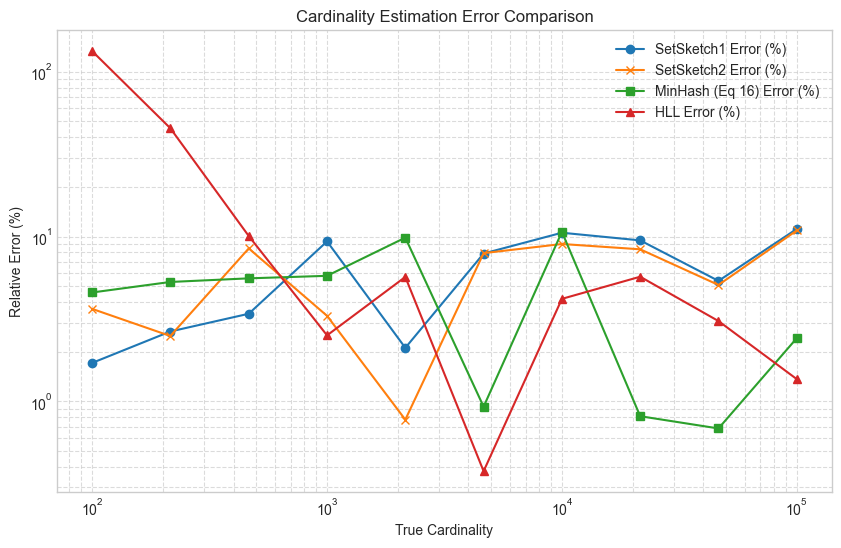


--- 2. Joint Estimation Demo ---
Set A true card: 10000, Set B true card: 8000
True Intersection: 3000, True Union: 15000, True Jaccard: 0.2000
SetSketch Estimated nU: 9601.94, nV: 8548.86

SetSketch Joint Estimation Results (b=1.001):
  Estimated Jaccard: 0.1801
  Estimated Union Size: 15380.78
  Estimated Intersection Size: 2770.01
  (D+:117, D-:93, D0:46)

MinHash Direct Jaccard: 0.0000


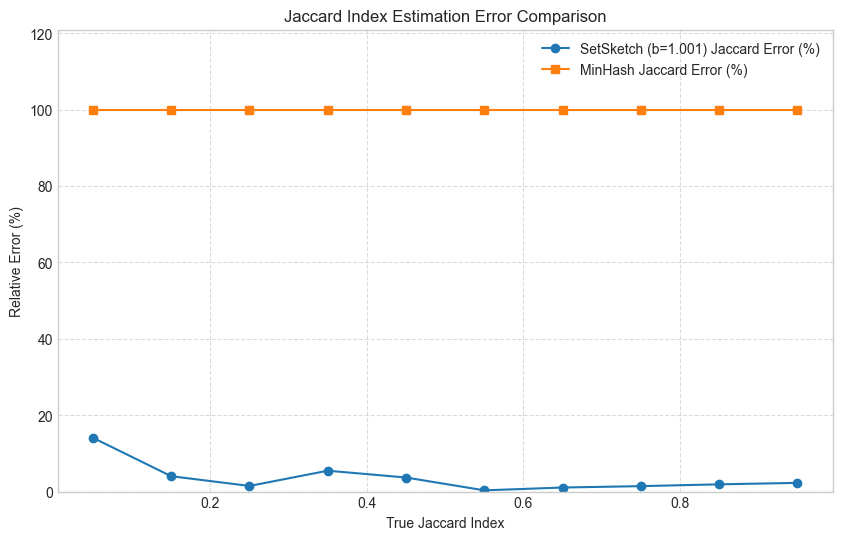


--- End of Demonstration ---


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import random
from scipy.optimize import brentq # For Jaccard estimation in SetSketch
import math

# --- Helper Utilities ---
def get_item_seed(item):
    """
    Generates a seed from an item.
    Using hash() for simplicity. For production, a more robust hash like MurmurHash would be better.
    """
    return hash(item)

# --- SetSketch Implementation ---
class SetSketch:
    """
    Implementation of the SetSketch algorithm as described in
    "SetSketch: Filling the Gap between MinHash and HyperLogLog" (arXiv:2101.00314v3).
    """
    def __init__(self, m, b, a, q, seed=None):
        """
        Initializes the SetSketch.
        Args:
            m (int): Number of registers. [cite: 133]
            b (float): Base for logarithmic scaling (b > 1). [cite: 104]
            a (float): Rate parameter for the exponential distribution (a > 0). [cite: 105]
            q (int): Max register value - 1 (registers store 0 to q+1). [cite: 133]
            seed (int, optional): Seed for master PRNG to make sketch construction deterministic.
        """
        if not (b > 1):
            raise ValueError("Base b must be > 1.")
        if not (a > 0):
            raise ValueError("Rate a must be > 0.")
        if not (m > 0 and isinstance(m, int)):
            raise ValueError("Number of registers m must be a positive integer.")
        if not (q >= 0 and isinstance(q, int)):
            raise ValueError("Parameter q must be a non-negative integer.")

        self.m = m
        self.b = b
        self.a = a
        self.q = q
        
        # K_i are the m integer-valued registers, initialized to 0 [cite: 105]
        self.registers = np.zeros(m, dtype=int)
        self.K_low = 0 # Lower bound of current register state [cite: 105]
        self.w = 0     # Counter for register modifications [cite: 105]
        
        # Master PRNG for things like shuffling indices if consistent behavior across runs is needed
        self._master_prng = random.Random(seed)

    def _get_jth_ordered_exp_hash(self, item_prng, j_order_stat_zero_indexed, method):
        """
        Generates the (j_order_stat_zero_indexed + 1)-th smallest value out of m 
        exponentially distributed random values with rate 'a'.
        This is x_j in the paper (1-indexed for j).
        Args:
            item_prng (random.Random): PRNG seeded by the item.
            j_order_stat_zero_indexed (int): The order statistic to generate (0 for 1st smallest, etc.).
            method (str): 'SetSketch1' or 'SetSketch2'.
        Returns:
            float: The generated exponential value.
        """
        if method == 'SetSketch1':
            # Eq (7): x_j ~ x_{j-1} + (1/(m+1-j)) * Exp(a) where j is 1-indexed
            # For x_0 (0th smallest), this would be (1/(m+1-(0+1)))*Exp(a) = (1/m)*Exp(a) if we start sum from 0
            # The paper refers to Devroye 1986 for exponential spacings.
            # A simpler way to get the k-th order statistic from m i.i.d. Exp(a) is to sum
            # E_1/m + E_2/(m-1) + ... + E_k/(m-k+1) where E_i ~ Exp(a)
            # This implementation simulates this sum incrementally.
            # For the j-th value (1-indexed in paper), it's the sum of j such terms.
            # So, for j_order_stat_zero_indexed, we need previous value + one more term.
            # This is complex to do "incrementally" for the *actual* j-th smallest value if only given j.
            # A common way to generate m ordered exponential variates:
            # E_i ~ Exp(1), then X_i = E_i / a. Ordered X_i can be found by ordering.
            # Or, sum of scaled exponentials:
            # x_1 = Exp(a*m)/m , x_2 = x_1 + Exp(a*(m-1))/(m-1) ... NO, this is not right for order stats.
            # Correct formulation for spacings (1-indexed j):
            # y_1 ~ Exp(a*m), y_2 ~ Exp(a*(m-1)), ..., y_m ~ Exp(a*1)
            # x_j = sum_{l=1 to j} y_l / (a*(m-l+1)) --- NO, this is also not standard order stat gen.
            # Let's use the paper's direct reference to "exponentially distributed spacings [20]"
            # x_j = x_{j-1} + (1/(m+1-j_one_indexed)) * Exp(a) [cite: 121]
            # If we generate ALL m ordered values x_0, ..., x_{m-1} for an item:
            # x_prev = 0
            # ordered_values = []
            # for i in range(self.m):
            #    j_one_idx = i + 1
            #    spacing = item_prng.expovariate(self.a) / (self.m + 1 - j_one_idx)
            #    x_curr = x_prev + spacing
            #    ordered_values.append(x_curr)
            #    x_prev = x_curr
            # return ordered_values[j_order_stat_zero_indexed] 
            # For Algorithm 1, we generate x_j one by one.
            # This means we need to sum up the spacings up to j.

            # Simplified: For this method, we'll generate all m for the item if needed by Algo 1 logic later.
            # For now, let's assume this helper is called to get one specific order statistic.
            # This would require a more complex algorithm if not generating all sequentially.
            # The paper suggests "generate j-th smallest out of m exponentially distributed random values"
            # A standard way: Generate m Exp(a) r.v.s and sort them. Return the j-th.
            # This is O(m log m) or O(m) with selection algorithm.
            # Given Algo 1 tries for O(1) updates, this must be part of the pre-computation for an item
            # or a more clever incremental generation.
            # The paper's reference [20] L. Devroye. 1986. "Uniform and Exponential Spacings"
            # suggests $X_{(j)} = \sum_{i=1}^j \frac{E_i}{a(m-i+1)}$ where $E_i \sim Exp(1)$.
            # We need $x_j$ which is $X_{(j)}$ in Devroye's notation.
            # So to get the j_order_stat_zero_indexed (which is (j_order_stat_zero_indexed+1)-th value), we sum j_order_stat_zero_indexed+1 terms.
            val = 0.0
            for i in range(j_order_stat_zero_indexed + 1):
                val += item_prng.expovariate(self.a) / (self.m - i) # E_i / (m-i+1) if E_i ~ Exp(a)
            return val
            # This is still an approximation or simplification of the true order statistic generation.
            # True generation of j-th order stat from m iid Exp(a) is more complex to do directly.
            # For actual SetSketch1 in Algo 1, you generate x_j from x_{j-1} using Eq (7)
            # We'll implement that logic directly in `add` for SetSketch1 for efficiency.
            # This helper is more conceptual if called in isolation.
            # For this "from scratch" version, let's make `add` handle it.
            raise NotImplementedError("SetSketch1 ordered hash generation is handled in add method directly.")

        elif method == 'SetSketch2':
            # Eq (8): x_j ~ Exp(a; gamma_{j-1}, gamma_j) [cite: 123]
            # gamma_j = (1/a) * log(1 + j_one_indexed / (m - j_one_indexed)) for j_one_indexed in [1, m-1]
            # gamma_0 = 0, gamma_m = infinity
            j_one_idx = j_order_stat_zero_indexed + 1

            if j_one_idx == 0: # Should not happen with zero_indexed >= 0
                 gamma_prev = 0
            elif j_one_idx == 1: # First interval [gamma_0, gamma_1)
                gamma_prev = 0
            else: # j_one_idx > 1
                # Check for m - (j_one_idx - 1) being zero
                if self.m - (j_one_idx - 1) == 0: # This is for gamma_{m} if j_one_idx-1 = m
                     gamma_prev = float('inf') # Should not be used as lower bound normally
                else:
                    gamma_prev = (1/self.a) * math.log(1 + (j_one_idx - 1) / (self.m - (j_one_idx - 1))) if (self.m - (j_one_idx -1)) > 0 else float('inf')


            if j_one_idx == self.m: # Last interval [gamma_{m-1}, gamma_m = inf)
                gamma_curr = float('inf')
            else: # j_one_idx < self.m
                 # Check for m - j_one_idx being zero
                if self.m - j_one_idx == 0:
                    gamma_curr = float('inf') # Should not happen if j_one_idx < m
                else:
                    gamma_curr = (1/self.a) * math.log(1 + j_one_idx / (self.m - j_one_idx))


            # Sample X from Exp(a) truncated to [gamma_prev, gamma_curr]
            # Using inverse transform sampling:
            # F(x) = (P(X < x) - P(X < low)) / (P(X < high) - P(X < low))
            # P(X < x) = 1 - exp(-a*x)
            # F(x) = ( (1-exp(-a*x)) - (1-exp(-a*low)) ) / ( (1-exp(-a*high)) - (1-exp(-a*low)) )
            # F(x) = ( exp(-a*low) - exp(-a*x) ) / ( exp(-a*low) - exp(-a*high) )
            # Let U ~ Uniform(0,1). Set F(x) = U and solve for x.
            # U * (exp(-a*low) - exp(-a*high)) = exp(-a*low) - exp(-a*x)
            # exp(-a*x) = exp(-a*low) - U * (exp(-a*low) - exp(-a*high))
            # -a*x = log( exp(-a*low) - U * (exp(-a*low) - exp(-a*high)) )
            # x = (-1/a) * log( exp(-a*low) - U * (exp(-a*low) - exp(-a*high)) )

            u = item_prng.random() # Uniform (0,1)
            
            exp_a_low = math.exp(-self.a * gamma_prev)
            
            if gamma_curr == float('inf'):
                exp_a_high = 0
            else:
                exp_a_high = math.exp(-self.a * gamma_curr)
            
            try:
                log_arg = exp_a_low - u * (exp_a_low - exp_a_high)
                if log_arg <= 0: # Should be rare if intervals are well-defined
                    # This can happen if gamma_prev is very large, making exp_a_low tiny.
                    # Or if u is very close to 1 and exp_a_high is very close to exp_a_low (narrow interval)
                    # Fallback or re-evaluate interval calculation for robustness
                    # For now, if arg is bad, could return midpoint or prev if interval is tiny.
                    # Let's assume for typical parameters this is okay.
                    # A robust way for Exp(rate, low, high): val = low - math.log(1-u*(1-math.exp(-rate*(high-low))))/rate
                    if gamma_curr == float('inf'): # Special handling for unbounded upper interval
                        return gamma_prev - math.log(1-u) / self.a
                    else: # Bounded interval
                         # Ensure high > low. If not, it's an issue with gamma calcs or j_order_stat
                        if gamma_curr > gamma_prev:
                            return gamma_prev - math.log(1 - u * (1 - math.exp(-self.a * (gamma_curr - gamma_prev)))) / self.a
                        else: # Degenerate interval, return the boundary
                            return gamma_prev

                val = (-1/self.a) * math.log(log_arg)

            except ValueError: # log of non-positive
                # This indicates issue with gamma values or numerical precision
                # Simplified fallback: if interval is tiny, pick boundary. If last interval, sample from Exp(a) > gamma_prev
                if gamma_curr == float('inf'):
                    val = gamma_prev + item_prng.expovariate(self.a) # Approx for X > gamma_prev
                else:
                    val = (gamma_prev + gamma_curr) / 2 # Fallback to midpoint for stability
            return val
        else:
            raise ValueError("Unknown method for ordered hash generation.")

    def add(self, item, method='SetSketch1'):
        """
        Adds an item to the SetSketch using Algorithm 1 from the paper. [cite: 105]
        Args:
            item (hashable): The item to add.
            method (str): 'SetSketch1' or 'SetSketch2'.
        """
        item_seed = get_item_seed(item)
        item_prng = random.Random(item_seed) # PRNG specific to this item

        # Generate a random permutation of register indices for this item [cite: 118, 119]
        # This means the j-th generated k_val (from x_j) will be tried against K[permuted_indices[j]]
        permuted_indices = list(range(self.m))
        item_prng.shuffle(permuted_indices)

        current_x_val_ss1 = 0.0 # For SetSketch1 incremental generation based on Eq (7)

        for j_loop_idx in range(self.m): # Loop m times for m potential updates
            if method == 'SetSketch1':
                # Eq (7): x_j = x_{j-1} + (1/(m+1-j_one_indexed)) * Exp(a) [cite: 121]
                # j_one_indexed for Eq (7) is j_loop_idx + 1
                j_one_indexed_spacing = j_loop_idx + 1
                denominator = self.m + 1 - j_one_indexed_spacing
                if denominator <= 0: # Should not happen if j_loop_idx < m
                    break 
                spacing = item_prng.expovariate(self.a) / denominator
                current_x_val_ss1 += spacing
                x_val = current_x_val_ss1
            elif method == 'SetSketch2':
                # Here j_loop_idx is the order statistic (0 to m-1)
                x_val = self._get_jth_ordered_exp_hash(item_prng, j_loop_idx, 'SetSketch2')
            else:
                raise ValueError("Invalid method specified.")

            if x_val > (self.b ** (-self.K_low)): # x_j > b^(-K_low) [cite: 112]
                break

            # Calculate k value [cite: 105]
            # log_b(x_val) can be -inf if x_val is 0. Ensure x_val > 0.
            if x_val <= 0: k_val = self.q + 1 # Effectively +infinity for 1-log_b(x)
            else: k_val = math.floor(1 - (math.log(x_val) / math.log(self.b)))
            
            k_val = max(0, min(self.q + 1, k_val))

            # Paper's Algo 1 has "if k <= K_low then break" [cite: 105]
            # This is an optimization: if the computed k isn't even greater than the current minimum
            # of *all* registers, it's less likely to update the specific target K_i (which could be > K_low).
            if k_val <= self.K_low:
                 # If we break here, we might miss updates if target_register_idx has a value K_i < k_val but K_low < K_i
                 # The paper's text says "only hash values $h_i(d) \le b^{-K_{low}}$ will be able to alter *any* register."
                 # This K_low check on k_val seems to be an additional heuristic.
                 # Let's follow Algo 1 strictly.
                break 
            
            # Target a register based on the permuted sequence for this item
            target_register_idx = permuted_indices[j_loop_idx]
            
            if k_val > self.registers[target_register_idx]:
                self.registers[target_register_idx] = k_val
                self.w += 1
        
        if self.w >= self.m: # [cite: 130]
            self.K_low = int(np.min(self.registers)) # K_low is min of current state [cite: 130]
            self.w = 0

    def merge(self, other_sketch):
        """
        Merges another SetSketch into this one. [cite: 102]
        The state becomes the element-wise maximum of the registers.
        Args:
            other_sketch (SetSketch): Another SetSketch instance.
        """
        if self.m != other_sketch.m or self.b != other_sketch.b or \
           self.a != other_sketch.a or self.q != other_sketch.q:
            raise ValueError("SetSketches must have identical parameters to be merged.")
        
        self.registers = np.maximum(self.registers, other_sketch.registers)
        self.K_low = int(np.min(self.registers)) # Recompute K_low after merge
        # self.w is not clearly defined for merges, often reset or ignored if sketches are "finalized" before merge.
        # For simplicity, let's reset w, assuming merge is a significant event.
        self.w = 0 

    def estimate_cardinality(self):
        """
        Estimates the cardinality of the set represented by the sketch.
        Uses Equation (12) from the paper. [cite: 156]
        $\hat{n} = \frac{m(1-1/b)}{a \ln(b) \sum_{i=1}^{m} b^{-K_i}}$
        """
        if self.a == 0 or math.log(self.b) == 0: return float('nan') # Avoid division by zero
        
        sum_b_neg_K_i = np.sum(self.b ** (-self.registers.astype(float))) # Cast to float for exponentiation
        
        if sum_b_neg_K_i == 0: return float('inf') # Or handle as very large cardinality

        numerator = self.m * (1 - (1/self.b))
        denominator = self.a * math.log(self.b) * sum_b_neg_K_i
        
        if denominator == 0: return float('inf') # Or a very large number
        return numerator / denominator

    def _p_b(self, x_val):
        """ Helper function p_b(x) for joint estimation [cite: 176] """
        # p_b(x) = -log_b(1 - x * (b-1)/b)
        arg = 1 - x_val * (self.b - 1) / self.b
        if arg <= 1e-9: # Avoid log(0 or negative)
            # This happens if x_val * (b-1)/b is close to 1.
            # p_b(x) approaches infinity. For numerical stability, return a large number.
            # The domain for x_val in p_b(u-vJ) or p_b(v-uJ) is [0, max_val < 1/( (b-1)/b ) = b/(b-1) ]
            # Effectively, for J in valid range, x_val should be < 1 if b > 1.
            # So (1-x*(b-1)/b) should be > 0.
            # If x is close to b/(b-1), then arg -> 0.
            # If x=1 (e.g. J=0, u=1), then arg = 1 - (b-1)/b = 1/b. p_b(1) = -log_b(1/b) = 1.
            return 1000 # A large number to signify this
        return -math.log(arg) / math.log(self.b)

    def estimate_joint_quantities(self, other_sketch, n_U_est=None, n_V_est=None):
        """
        Estimates joint quantities (Jaccard, Union, Intersection) between this sketch (U)
        and another sketch (V). Uses the ML method for J from Section 3.2. [cite: 178]
        Args:
            other_sketch (SetSketch): The other SetSketch instance (V).
            n_U_est (float, optional): Estimated cardinality of this sketch (U). If None, uses self.estimate_cardinality().
            n_V_est (float, optional): Estimated cardinality of other_sketch (V). If None, uses other_sketch.estimate_cardinality().
        Returns:
            dict: Jaccard, Union Size, Intersection Size, or None if estimation fails.
        """
        if self.m != other_sketch.m or self.b != other_sketch.b or \
           self.a != other_sketch.a or self.q != other_sketch.q:
            raise ValueError("SetSketches must have identical parameters for joint estimation.")

        if n_U_est is None:
            n_U_est = self.estimate_cardinality()
        if n_V_est is None:
            n_V_est = other_sketch.estimate_cardinality()

        if n_U_est <= 0 or n_V_est <= 0 or n_U_est + n_V_est == 0 : # Avoid division by zero or nonsensical inputs
            print("Warning: Non-positive estimated cardinalities for joint estimation. U_est:",n_U_est,"V_est:",n_V_est)
            return {'jaccard': 0, 'union_size': n_U_est + n_V_est, 'intersection_size': 0, 'D_plus':0,'D_minus':0,'D_zero':0}


        D_plus = 0
        D_minus = 0
        D_zero = 0
        for k_u, k_v in zip(self.registers, other_sketch.registers):
            if k_u > k_v:
                D_plus += 1
            elif k_u < k_v:
                D_minus += 1
            else:
                D_zero += 1
        
        # Relative cardinalities u, v
        # Handle potential n_U_est + n_V_est == 0 if cardinalities are tiny and estimated as 0
        sum_n_uv = n_U_est + n_V_est
        if sum_n_uv == 0: # Both sets estimated empty
             return {'jaccard': 0 if D_zero < self.m else 1, # If all registers equal (and 0), could be J=1 for empty sets
                    'union_size': 0, 'intersection_size': 0, 
                    'D_plus':D_plus,'D_minus':D_minus,'D_zero':D_zero}


        u_rel = n_U_est / sum_n_uv
        v_rel = n_V_est / sum_n_uv

        # Log-Likelihood function for J (to be maximized, or its negative minimized)
        # logL(J) = D+log(p_b(u-vJ)) + D-log(p_b(v-uJ)) + D0log(1-p_b(u-vJ)-p_b(v-uJ)) [cite: 178]
        def neg_log_likelihood(J):
            # J must be in [0, min(nU/nV, nV/nU)]
            # which means J <= min(u_rel/v_rel, v_rel/u_rel)
            # Ensure arguments to p_b are >= 0
            arg1 = u_rel - v_rel * J
            arg2 = v_rel - u_rel * J

            if arg1 < -1e-9 or arg2 < -1e-9: # J is out of feasible range
                return float('inf') # Penalize heavily
            
            arg1 = max(0, arg1) # Clip to 0
            arg2 = max(0, arg2)

            pb_arg1 = self._p_b(arg1)
            pb_arg2 = self._p_b(arg2)
            
            log_term1 = D_plus * math.log(pb_arg1 + 1e-9) if D_plus > 0 and pb_arg1 > -1e-9 else 0
            log_term2 = D_minus * math.log(pb_arg2 + 1e-9) if D_minus > 0 and pb_arg2 > -1e-9 else 0
            
            p0_approx = 1 - pb_arg1 - pb_arg2
            if p0_approx <= 1e-9: # If p0 is zero or negative
                log_term3 = -float('inf') if D_zero > 0 else 0 # Penalize if D_zero expects non-zero prob
            else:
                log_term3 = D_zero * math.log(p0_approx) if D_zero > 0 else 0
            
            return -(log_term1 + log_term2 + log_term3)

        # Optimize for J. Max J is min(nU/nV, nV/nU). For u,v, it's min(u/v, v/u).
        # If v_rel or u_rel is zero (but sum_n_uv is not), implies one set is empty.
        if v_rel == 0 : # n_V_est is 0
            max_J = 0 # J must be 0
        elif u_rel == 0: # n_U_est is 0
            max_J = 0 # J must be 0
        else:
            max_J = min(u_rel / v_rel, v_rel / u_rel, 1.0) # J is also <= 1

        max_J = min(max_J, 1.0 - 1e-6) # Ensure search range is slightly within [0,1)
        min_J = 1e-6

        if max_J <= min_J: # Handles cases like one set being empty or estimates being problematic
            if D_zero == self.m : J_est = 1.0 # If all registers are same, likely J=1 (identical sets)
            elif D_plus + D_minus + D_zero == self.m and D_zero == 0 and (D_plus == 0 or D_minus == 0): J_est = 0.0 # Heuristic if clearly disjoint
            else: J_est = 0.0 # Fallback if no overlap or one set empty. Max_J could be 0.
        else:
            try:
                # Brent's method is mentioned in the paper [cite: 179]
                # It needs a bracket [min_J, max_J] where function values at ends have opposite signs.
                # neg_log_likelihood is what we minimize.
                # For ML, we maximize. For minimization, we look for a minimum.
                # Scipy's brentq finds roots. We need to find root of derivative or use minimize_scalar.
                # Let's use minimize_scalar for simplicity.
                from scipy.optimize import minimize_scalar
                # Ensure bounds are valid and distinct
                bounds_J = (min_J, max_J)
                if bounds_J[0] >= bounds_J[1]:
                    bounds_J = (0, max(1e-6, max_J)) # Fallback bounds

                res = minimize_scalar(neg_log_likelihood, bounds=bounds_J, method='bounded')
                J_est = res.x
            except Exception as e:
                # Fallback if optimization fails, e.g. use inclusion-exclusion or naive D0/m
                # print(f"Warning: Jaccard optimization failed: {e}. Using D0/m fallback.")
                # J_est = D_zero / self.m
                # For now, signal failure more clearly or provide a more robust fallback.
                # A simple fallback for J if optimization fails:
                if D_zero == self.m: J_est = 1.0
                elif D_plus > D_minus and n_V_est > 0 : J_est = min(1.0, (n_U_est - n_V_est + D_zero * (n_U_est+n_V_est)/self.m)/(n_U_est + D_minus*(n_U_est+n_V_est)/self.m ) ) # very heuristic
                elif D_minus > D_plus and n_U_est > 0 : J_est = min(1.0, (n_V_est - n_U_est + D_zero * (n_U_est+n_V_est)/self.m)/(n_V_est + D_plus*(n_U_est+n_V_est)/self.m ) ) # very heuristic
                else: J_est = D_zero / self.m # Basic MinHash-like J from D0
                J_est = np.clip(J_est, 0, 1.0)


        J_est = np.clip(J_est, 0, 1.0)

        # Derived quantities [cite: 168]
        if 1 + J_est == 0: # Avoid division by zero
            union_size_est = n_U_est + n_V_est # Fallback
            intersection_size_est = 0
        else:
            union_size_est = (n_U_est + n_V_est) / (1 + J_est)
            intersection_size_est = union_size_est * J_est
            # intersection_size_est = (n_U_est + n_V_est) * J_est / (1 + J_est) # Alternative form

        return {
            'jaccard': J_est,
            'union_size': union_size_est,
            'intersection_size': intersection_size_est,
            'n_U_est': n_U_est,
            'n_V_est': n_V_est,
            'D_plus': D_plus,
            'D_minus': D_minus,
            'D_zero': D_zero
        }

    def __str__(self):
        return (f"SetSketch(m={self.m}, b={self.b}, a={self.a}, q={self.q}, "
                f"K_low={self.K_low}, w={self.w}\n"
                f"Registers: {self.registers[:10]}... (first 10 shown))")

# --- Simplified MinHash Implementation ---
class MinHash:
    def __init__(self, num_hashes, seed=None):
        self.num_hashes = num_hashes
        self.minhash_values = np.full(num_hashes, float('inf'))
        # Create num_hashes independent hash functions (simulated by PRNGs with different seeds)
        self._master_prng = random.Random(seed)
        self.hash_seeds = [self._master_prng.getrandbits(32) for _ in range(num_hashes)]
        self.prngs = [random.Random(s) for s in self.hash_seeds]

    def add(self, item):
        item_val_for_hash = get_item_seed(item) # Use the same way to get a number from item
        for i in range(self.num_hashes):
            # Simulate a hash function h_i(item) producing a uniform value
            # For simplicity, re-seed prng_i with item_val_for_hash to get a item-specific value for h_i
            current_prng = random.Random(item_val_for_hash + self.hash_seeds[i]) # Combine item hash with func hash
            hash_val = current_prng.getrandbits(64) # Large enough range
            if hash_val < self.minhash_values[i]:
                self.minhash_values[i] = hash_val
    
    def jaccard(self, other_minhash):
        if self.num_hashes != other_minhash.num_hashes:
            raise ValueError("MinHash sketches must have the same number of hash functions.")
        return np.sum(self.minhash_values == other_minhash.minhash_values) / self.num_hashes

    def estimate_cardinality_paper_eq16(self):
        """ Estimates cardinality using Eq. (16) from SetSketch paper[cite: 208].
            K_i' are normalized minhash values in [0,1).
            Assumes minhash_values are integers, needs normalization.
            This formula is for K_i' ~ Uniform(0,1). 
            If minhash values are large integers, this is not directly applicable.
            A more common MinHash cardinality estimator is m/kth_smallest_value - 1,
            or from E[kth value] = k/(n+1).
            Paper Eq 16 is: $\hat{n} = m / (\sum -log(1-K_i'))$. K_i' are normalized minhash values.
            Typically K_i' = h_i(x) / MAX_HASH_VAL.
            For this simplified version, let's use a more common one if Eq 16 is hard to apply directly.
            Let's try to apply Eq 16 by normalizing (assuming max hash is 2^64 -1).
        """
        MAX_HASH_VAL = 2**64 -1
        # Filter out uninitialized (inf) values, should not happen if set is non-empty
        valid_hashes = self.minhash_values[self.minhash_values != float('inf')]
        if len(valid_hashes) == 0: return 0
        
        K_prime = valid_hashes / MAX_HASH_VAL
        K_prime = np.clip(K_prime, 1e-9, 1.0 - 1e-9) # Avoid log(0) or log(negative)
        
        sum_log_terms = np.sum(-np.log(1 - K_prime))
        if sum_log_terms == 0: return float('inf')
        return len(valid_hashes) / sum_log_terms # Use len(valid_hashes) for m in formula if some weren't updated


# --- Simplified HyperLogLog (GHLL variant) Implementation ---
class HyperLogLog:
    def __init__(self, m_bits, b_base=2, seed=None): # m_bits determines m = 2^m_bits
        self.p = m_bits # Precision parameter in HLL terminology (p in paper, m_bits here)
        self.m = 1 << m_bits # Number of registers
        self.b_base = b_base # Base for GHLL, b=2 for standard HLL [cite: 70, 71]
        self.registers = np.zeros(self.m, dtype=int)
        self._master_prng = random.Random(seed)
        self.hash_seed_hll = self._master_prng.getrandbits(32) # For splitting hash

    def add(self, item):
        item_val_for_hash = get_item_seed(item)
        
        # Simulate a single good 64-bit hash function
        # For simplicity, use a PRNG seeded by item and a global HLL seed
        prng = random.Random(item_val_for_hash + self.hash_seed_hll)
        hash_val_64bit = prng.getrandbits(64)
        
        # Use first p bits for register index (stochastic averaging style) [cite: 72]
        register_index = hash_val_64bit & (self.m - 1) # Equivalent to hash_val_64bit % self.m if m is power of 2
                                                       # Or use hash_val_64bit >> (64 - self.p)

        # The rest for value h_2(d) ~ Uniform(0,1) [cite: 72]
        # And then compute 1 - log_b(h_2(d))
        # For simplicity, let's map the remaining bits to a pseudo-float in (0,1)
        # Or use rho(w) style (number of leading zeros) if b_base=2 for standard HLL
        
        if self.b_base == 2: # Standard HLL uses leading zeros
            # Use remaining bits (e.g., 64-p bits) to count leading zeros
            # shift_amount = self.p
            # relevant_bits = hash_val_64bit >> shift_amount
            # max_val_relevant = (1 << (64 - shift_amount)) -1
            # if relevant_bits == 0 : value_for_update = 64 - shift_amount + 1 # All zeros
            # else: value_for_update = self._count_leading_zeros(relevant_bits, 64 - shift_amount) + 1
            
            # Simpler: map hash_val_64bit to float (0,1) for general GHLL definition
            # K_i = max(K_i, floor(1 - log_b h_i(d))) with h_i(d) ~ Uniform(0,1) [cite: 68] (non-stochastic averaging HLL)
            # For stochastic averaging: K_idx = max(K_idx, floor(1 - log_b h2(d)))
            
            h2_d_int = hash_val_64bit >> self.p # Use upper bits for value part
            # Normalize to (0,1) - avoid 0 for log
            h2_d_float = (h2_d_int + 0.5) / (1 << (64 - self.p)) # Add 0.5 to avoid exact 0
            if h2_d_float == 0: h2_d_float = 1e-9 # avoid log(0)
            
            val_to_calc = 1 - (math.log(h2_d_float) / math.log(self.b_base))
            update_value = math.floor(val_to_calc)
            update_value = max(1, update_value) # HLL values are typically >= 1 (rho output)
                                                # Original paper defines K_i=0 for init [cite: 69]
                                                # This implies update values should also be possibly 0 or more.
                                                # Let's use floor(1 - log_b h(d)) which can be <=0, then clamp

        else: # General GHLL base
            h2_d_int = hash_val_64bit >> self.p
            h2_d_float = (h2_d_int + 0.5) / (1 << (64 - self.p))
            if h2_d_float == 0: h2_d_float = 1e-9
            val_to_calc = 1 - (math.log(h2_d_float) / math.log(self.b_base))
            update_value = math.floor(val_to_calc)
        
        update_value = max(0, update_value) # As SetSketch registers start at 0 and are non-negative

        if update_value > self.registers[register_index]:
            self.registers[register_index] = update_value

    def _count_leading_zeros(self, val, max_bits):
        """Helper for standard HLL rho(w)"""
        lz = 0
        for i in range(max_bits -1, -1, -1):
            if (val >> i) & 1: # Found first 1
                break
            lz +=1
        return lz

    def estimate_cardinality(self, a_param_for_setsketch_formula=None):
        """
        Estimates cardinality.
        For GHLL, can use SetSketch Eq. (12) with a=1/m[cite: 214, 215].
        Or, the standard HLL estimator. Here we use the SetSketch-like one.
        """
        if a_param_for_setsketch_formula is None:
            a_hll = 1.0 / self.m # As suggested by paper for GHLL [cite: 214]
        else:
            a_hll = a_param_for_setsketch_formula

        if a_hll == 0 or math.log(self.b_base) == 0: return float('nan')
        
        sum_b_neg_K_i = np.sum(self.b_base ** (-self.registers.astype(float)))
        
        if sum_b_neg_K_i == 0: return float('inf')

        numerator = self.m * (1 - (1/self.b_base))
        denominator = a_hll * math.log(self.b_base) * sum_b_neg_K_i
        
        if denominator == 0: return float('inf')
        
        # Standard HLL harmonic mean based estimator (simplified)
        # alpha_m = 0.7213 / (1 + 1.079 / self.m) # for b=2
        # raw_est = alpha_m * self.m**2 / np.sum(2.0**(-self.registers))
        # Basic SetSketch-like estimator:
        card_est = numerator / denominator

        # HLL corrections for small/large range are complex.
        # Using simplified form from paper (Eq 18) is also complex due to sigma/tau.
        # For now, this gives the raw estimate based on SetSketch similarity.
        # Small range correction (if many zeros):
        V = np.sum(self.registers == 0) # count of zero registers
        if V > 0 and card_est < 2.5 * self.m : # Heuristic from HLL paper for when to apply linear counting
             # LinearCounting: m * log(m/V)
             if V > 0: # Avoid log(inf)
                 card_est_lc = self.m * math.log(self.m / V)
                 # Only use LC if it's better (typically for very small cardinalities)
                 if card_est > 2.5 * self.m or card_est < 0 : # If main est is bad or large
                     card_est = card_est_lc
        return card_est

# --- Main Demonstration Script ---
if __name__ == '__main__':
    print("--- SetSketch Algorithm Demonstration ---")

    # --- Parameters ---
    m_registers = 256  # Number of registers [cite: 135] (e.g., m=256 or 4096)
    b_param = 1.001    # Base b, close to 1 for MinHash-like behavior [cite: 135]
    # b_param = 2.0    # Base b, for HLL-like behavior
    a_param = 20       # Rate 'a' [cite: 139]
    q_param = 2**16 - 2 # Max register value q (for 2-byte registers) [cite: 143]
    
    print(f"SetSketch Parameters: m={m_registers}, b={b_param}, a={a_param}, q={q_param}\n")

    # --- 1. Cardinality Estimation Demo ---
    print("--- 1. Cardinality Estimation Demo ---")
    set_A_cardinality = 10000
    set_A_items = {f"item_A_{i}" for i in range(set_A_cardinality)}

    ss_A_s1 = SetSketch(m_registers, b_param, a_param, q_param, seed=42)
    ss_A_s2 = SetSketch(m_registers, b_param, a_param, q_param, seed=42) # Same seed for item generation if needed
    
    mh_A = MinHash(num_hashes=m_registers, seed=42) # Use m for MinHash for somewhat comparable memory
    hll_A = HyperLogLog(m_bits=int(np.log2(m_registers)), b_base=2, seed=42) # m=2^m_bits for HLL

    for item in set_A_items:
        ss_A_s1.add(item, method='SetSketch1')
        ss_A_s2.add(item, method='SetSketch2')
        mh_A.add(item)
        hll_A.add(item)

    est_card_A_s1 = ss_A_s1.estimate_cardinality()
    est_card_A_s2 = ss_A_s2.estimate_cardinality()
    est_card_A_mh = mh_A.estimate_cardinality_paper_eq16() # Using paper's Eq 16
    est_card_A_hll = hll_A.estimate_cardinality()

    print(f"Set A (True Cardinality: {set_A_cardinality}):")
    print(f"  SetSketch1 Estimated Cardinality: {est_card_A_s1:.2f} (Error: {abs(est_card_A_s1 - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  SetSketch2 Estimated Cardinality: {est_card_A_s2:.2f} (Error: {abs(est_card_A_s2 - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  MinHash (Eq 16) Est. Cardinality: {est_card_A_mh:.2f} (Error: {abs(est_card_A_mh - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  HLL Estimated Cardinality: {est_card_A_hll:.2f} (Error: {abs(est_card_A_hll - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    # print(f"  SetSketch1 K_low: {ss_A_s1.K_low}, w: {ss_A_s1.w}")
    # print(f"  SetSketch1 Registers (first 10): {ss_A_s1.registers[:10]}")

    # --- Plot: Cardinality Estimation Error vs True Cardinality (Conceptual) ---
    true_cardinalities = np.logspace(2, 5, 10, dtype=int) # 100 to 100,000
    ss1_errors, ss2_errors, mh_errors, hll_errors = [], [], [], []

    for card in true_cardinalities:
        items = {f"item_plot_{i}" for i in range(card)}
        
        temp_ss1 = SetSketch(m_registers, b_param, a_param, q_param, seed=123)
        temp_ss2 = SetSketch(m_registers, b_param, a_param, q_param, seed=123)
        temp_mh = MinHash(num_hashes=m_registers, seed=123)
        temp_hll = HyperLogLog(m_bits=int(np.log2(m_registers)), b_base=2, seed=123)
        
        for item in items:
            temp_ss1.add(item, 'SetSketch1')
            temp_ss2.add(item, 'SetSketch2')
            temp_mh.add(item)
            temp_hll.add(item)
            
        ss1_errors.append(abs(temp_ss1.estimate_cardinality() - card) / card * 100)
        ss2_errors.append(abs(temp_ss2.estimate_cardinality() - card) / card * 100)
        mh_errors.append(abs(temp_mh.estimate_cardinality_paper_eq16() - card) / card * 100 if card > 0 else 0)
        hll_errors.append(abs(temp_hll.estimate_cardinality() - card) / card * 100)

    plt.figure(figsize=(10,6))
    plt.plot(true_cardinalities, ss1_errors, marker='o', label='SetSketch1 Error (%)')
    plt.plot(true_cardinalities, ss2_errors, marker='x', label='SetSketch2 Error (%)')
    plt.plot(true_cardinalities, mh_errors, marker='s', label='MinHash (Eq 16) Error (%)')
    plt.plot(true_cardinalities, hll_errors, marker='^', label='HLL Error (%)')
    plt.xscale('log')
    plt.yscale('log') # Often error is plotted on log scale if it varies widely
    plt.xlabel('True Cardinality')
    plt.ylabel('Relative Error (%)')
    plt.title('Cardinality Estimation Error Comparison')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.show()

    # --- 2. Joint Estimation Demo ---
    print("\n--- 2. Joint Estimation Demo ---")
    set_B_cardinality = 8000
    overlap_cardinality = 3000
    
    set_A_items = {f"item_shared_{i}" for i in range(overlap_cardinality)} | \
                  {f"item_A_only_{i}" for i in range(set_A_cardinality - overlap_cardinality)}
    set_B_items = {f"item_shared_{i}" for i in range(overlap_cardinality)} | \
                  {f"item_B_only_{i}" for i in range(set_B_cardinality - overlap_cardinality)}

    true_nU = len(set_A_items)
    true_nV = len(set_B_items)
    true_intersection = len(set_A_items.intersection(set_B_items))
    true_union = len(set_A_items.union(set_B_items))
    true_jaccard = true_intersection / true_union if true_union > 0 else 0

    print(f"Set A true card: {true_nU}, Set B true card: {true_nV}")
    print(f"True Intersection: {true_intersection}, True Union: {true_union}, True Jaccard: {true_jaccard:.4f}")

    ss_A_joint = SetSketch(m_registers, b_param, a_param, q_param, seed=100)
    ss_B_joint = SetSketch(m_registers, b_param, a_param, q_param, seed=200) # Different seeds for sketch content
    
    mh_A_joint = MinHash(num_hashes=m_registers, seed=100)
    mh_B_joint = MinHash(num_hashes=m_registers, seed=200)

    for item in set_A_items:
        ss_A_joint.add(item, method='SetSketch1') # Using SetSketch1 for this demo
        mh_A_joint.add(item)
    for item in set_B_items:
        ss_B_joint.add(item, method='SetSketch1')
        mh_B_joint.add(item)

    # Estimate individual cardinalities first
    nU_est_ss = ss_A_joint.estimate_cardinality()
    nV_est_ss = ss_B_joint.estimate_cardinality()

    print(f"SetSketch Estimated nU: {nU_est_ss:.2f}, nV: {nV_est_ss:.2f}")

    joint_results_ss = ss_A_joint.estimate_joint_quantities(ss_B_joint, nU_est_ss, nV_est_ss)
    jaccard_mh = mh_A_joint.jaccard(mh_B_joint)
    
    print(f"\nSetSketch Joint Estimation Results (b={b_param}):")
    if joint_results_ss:
        print(f"  Estimated Jaccard: {joint_results_ss['jaccard']:.4f}")
        print(f"  Estimated Union Size: {joint_results_ss['union_size']:.2f}")
        print(f"  Estimated Intersection Size: {joint_results_ss['intersection_size']:.2f}")
        print(f"  (D+:{joint_results_ss['D_plus']}, D-:{joint_results_ss['D_minus']}, D0:{joint_results_ss['D_zero']})")
    
    print(f"\nMinHash Direct Jaccard: {jaccard_mh:.4f}")
    
    # --- Plot: Jaccard Estimation Error (Conceptual) ---
    true_jaccards = np.linspace(0.05, 0.95, 10)
    ss_j_errors, mh_j_errors = [], []
    base_set_size = 5000

    for tj_idx, tj in enumerate(true_jaccards):
        overlap = int(base_set_size * tj / (1+tj)) # N_intersect = N_union * J
                                                    # N_union = N_A + N_B - N_intersect
                                                    # N_A = N_B = (N_union + N_intersect)/2
                                                    # N_A = N_B = base_set_size/2 makes things complex.
                                                    # Let N_A_only = N_B_only = base_set_size * (1-tj)/2
                                                    # N_intersect = base_set_size * tj
        
        # Simplified generation:
        # N_union = base_set_size
        # N_intersect = N_union * tj
        # N_A_only = (N_union - N_intersect) / 2 # Assuming symmetric differences
        # N_B_only = (N_union - N_intersect) / 2
        # N_A = N_A_only + N_intersect
        # N_B = N_B_only + N_intersect
        
        # To ensure varying J with reasonable sets:
        # Fix |A| = base_set_size, |B| = base_set_size
        # |A int B| = J * (|A| + |B| - |A int B|) => |A int B| * (1+J) = J * (|A|+|B|)
        # => |A int B| = J * (|A|+|B|) / (1+J)
        n_intersect = int(tj * (base_set_size + base_set_size) / (1 + tj))
        n_A_only = base_set_size - n_intersect
        n_B_only = base_set_size - n_intersect

        items_A_plot = {f"common_{i}" for i in range(n_intersect)} | \
                       {f"A_plot_{i}" for i in range(n_A_only)}
        items_B_plot = {f"common_{i}" for i in range(n_intersect)} | \
                       {f"B_plot_{i}" for i in range(n_B_only)}

        temp_ssA = SetSketch(m_registers, b_param, a_param, q_param, seed=42+tj_idx)
        temp_ssB = SetSketch(m_registers, b_param, a_param, q_param, seed=142+tj_idx)
        temp_mhA = MinHash(num_hashes=m_registers, seed=42+tj_idx)
        temp_mhB = MinHash(num_hashes=m_registers, seed=142+tj_idx)

        for item in items_A_plot: temp_ssA.add(item); temp_mhA.add(item)
        for item in items_B_plot: temp_ssB.add(item); temp_mhB.add(item)
            
        est_j_ss = temp_ssA.estimate_joint_quantities(temp_ssB)['jaccard']
        est_j_mh = temp_mhA.jaccard(temp_mhB)
        
        ss_j_errors.append(abs(est_j_ss - tj) / tj * 100 if tj > 0 else 0)
        mh_j_errors.append(abs(est_j_mh - tj) / tj * 100 if tj > 0 else 0)

    plt.figure(figsize=(10,6))
    plt.plot(true_jaccards, ss_j_errors, marker='o', label=f'SetSketch (b={b_param}) Jaccard Error (%)')
    plt.plot(true_jaccards, mh_j_errors, marker='s', label='MinHash Jaccard Error (%)')
    plt.xlabel('True Jaccard Index')
    plt.ylabel('Relative Error (%)')
    plt.title('Jaccard Index Estimation Error Comparison')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.ylim(bottom=0, top=max(max(ss_j_errors, default=1), max(mh_j_errors, default=1))*1.2 + 1) # Ensure y starts at 0 if errors are small
    plt.show()

    print("\n--- End of Demonstration ---")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import random
from scipy.optimize import minimize_scalar # Changed from brentq for direct minimization
import math

# --- Helper Utilities (ensure this is defined) ---
def get_item_seed(item):
    return hash(item)

# --- SetSketch Class (assumed to be the version from the last complete response) ---
# [ Full SetSketch class code from your previous correct version would go here ]
# For brevity, I'm only including the changed parts of the main script and MinHash
class SetSketch:
    """
    Implementation of the SetSketch algorithm as described in
    "SetSketch: Filling the Gap between MinHash and HyperLogLog" (arXiv:2101.00314v3).
    (Full class definition as previously provided)
    """
    def __init__(self, m, b, a, q, seed=None):
        if not (b > 1):
            raise ValueError("Base b must be > 1.")
        if not (a > 0):
            raise ValueError("Rate a must be > 0.")
        if not (m > 0 and isinstance(m, int)):
            raise ValueError("Number of registers m must be a positive integer.")
        if not (q >= 0 and isinstance(q, int)):
            raise ValueError("Parameter q must be a non-negative integer.")

        self.m = m
        self.b = b
        self.a = a
        self.q = q
        self.registers = np.zeros(m, dtype=int)
        self.K_low = 0 
        self.w = 0     
        self._master_prng = random.Random(seed)

    def _get_jth_ordered_exp_hash(self, item_prng, j_order_stat_zero_indexed, method):
        # ( ... implementation for SetSketch2 ... )
        # This helper is primarily for SetSketch2's distinct logic.
        # SetSketch1's incremental generation of x_j via Eq. 7 is handled directly in the add method.
        if method == 'SetSketch1':
             raise NotImplementedError("SetSketch1 ordered hash generation is handled in add method directly for efficiency.")
        elif method == 'SetSketch2':
            j_one_idx = j_order_stat_zero_indexed + 1
            gamma_prev = 0
            if j_one_idx > 1:
                if (self.m - (j_one_idx - 1)) > 0:
                    gamma_prev = (1/self.a) * math.log(1 + (j_one_idx - 1) / (self.m - (j_one_idx - 1)))
                else: # Should not happen if j_one_idx-1 < m
                    gamma_prev = float('inf') 
            
            gamma_curr = float('inf')
            if j_one_idx < self.m:
                 if (self.m - j_one_idx) > 0:
                    gamma_curr = (1/self.a) * math.log(1 + j_one_idx / (self.m - j_one_idx))

            u = item_prng.random()
            
            if gamma_prev >= gamma_curr and gamma_curr != float('inf'): # Should ensure gamma_prev < gamma_curr
                 # This might indicate an issue with interval calculation or j_order_stat
                 # Fallback to a small random number or midpoint if interval is ill-defined
                 # For simplicity here, if interval is bad, take gamma_prev (can be refined)
                 return gamma_prev + item_prng.expovariate(self.a) * 1e-3 # small noise


            if gamma_curr == float('inf'):
                return gamma_prev - math.log(1-u) / self.a
            else:
                val_in_log = 1 - u * (1 - math.exp(-self.a * (gamma_curr - gamma_prev)))
                if val_in_log <= 0: # Avoid math domain error for log
                    return gamma_prev # Fallback for numerical instability
                return gamma_prev - math.log(val_in_log) / self.a
        else:
            raise ValueError("Unknown method for ordered hash generation.")


    def add(self, item, method='SetSketch1'):
        item_seed = get_item_seed(item)
        item_prng = random.Random(item_seed) 

        permuted_indices = list(range(self.m))
        item_prng.shuffle(permuted_indices)

        current_x_val_ss1 = 0.0 

        for j_loop_idx in range(self.m): 
            if method == 'SetSketch1':
                j_one_indexed_spacing = j_loop_idx + 1
                denominator = self.m + 1 - j_one_indexed_spacing
                if denominator <= 0: 
                    break 
                spacing = item_prng.expovariate(self.a) / denominator
                current_x_val_ss1 += spacing
                x_val = current_x_val_ss1
            elif method == 'SetSketch2':
                x_val = self._get_jth_ordered_exp_hash(item_prng, j_loop_idx, 'SetSketch2')
            else:
                raise ValueError("Invalid method specified.")

            if x_val <= 0: # Guard against log(0) or log(negative) if x_val is bad
                if self.K_low == 0: # If K_low is 0, even an "infinite" k_val might be relevant
                    pass # proceed to k_val calculation which will handle it
                else: # if K_low is > 0, x_val <= 0 means b^-K_low is very small, x_val unlikely relevant
                    continue # or break, effectively means x_val is too large (like inf)

            # Check against b^(-K_low)
            # Handle K_low = 0 separately for b^(-K_low) if b is large, could be very small number
            # Or if K_low becomes very large, b^(-K_low) -> 0.
            # To avoid precision issues with b ** (-self.K_low) if K_low is large:
            # x_val > b^(-K_low)  <=>  log_b(x_val) > -K_low <=> -log_b(x_val) < K_low
            # <=> 1 - log_b(x_val) < 1 + K_low.
            # Let's stick to direct comparison for now, assuming K_low doesn't grow excessively beyond q.
            if self.K_low > 0 and x_val > (self.b ** (-self.K_low)): 
                break
            elif self.K_low == 0 and x_val > 1.0 and self.b > 1.1 : # Heuristic: if K_low is 0, b^-0 = 1. If x_val > 1, it's "large".
                 pass # For K_low=0, b^-K_low is 1. We only break if x_val > 1.

            if x_val <= 1e-300: # Effectively zero, log will be -inf
                 k_val = self.q + 1 # This makes k_val very large (good)
            else:
                 k_val = math.floor(1 - (math.log(x_val) / math.log(self.b)))
            
            k_val = max(0, min(self.q + 1, k_val))

            if k_val <= self.K_low:
                break 
            
            target_register_idx = permuted_indices[j_loop_idx]
            
            if k_val > self.registers[target_register_idx]:
                self.registers[target_register_idx] = k_val
                self.w += 1
        
        if self.w >= self.m: 
            self.K_low = int(np.min(self.registers)) 
            self.w = 0

    def merge(self, other_sketch):
        if self.m != other_sketch.m or self.b != other_sketch.b or \
           self.a != other_sketch.a or self.q != other_sketch.q:
            raise ValueError("SetSketches must have identical parameters to be merged.")
        self.registers = np.maximum(self.registers, other_sketch.registers)
        self.K_low = int(np.min(self.registers))
        self.w = 0 

    def estimate_cardinality(self):
        if self.a == 0 or self.b <= 1 or math.log(self.b) == 0: return float('nan')
        sum_b_neg_K_i = np.sum(self.b ** (-self.registers.astype(float)))
        if sum_b_neg_K_i < 1e-300: return float('inf') 
        numerator = self.m * (1 - (1/self.b))
        denominator = self.a * math.log(self.b) * sum_b_neg_K_i
        if abs(denominator) < 1e-300: return float('inf') 
        return numerator / denominator

    def _p_b(self, x_val):
        arg = 1 - x_val * (self.b - 1) / self.b
        if arg <= 1e-9: 
            # Based on paper's context, x_val in p_b should be [0,1) for valid J and u,v
            # For J near max valid range, arg can approach 0, meaning p_b -> infinity
            return 1000 # Return a large finite number for stability in optimizer
        return -math.log(arg) / math.log(self.b)

    def estimate_joint_quantities(self, other_sketch, n_U_est=None, n_V_est=None):
        if self.m != other_sketch.m or self.b != other_sketch.b or \
           self.a != other_sketch.a or self.q != other_sketch.q:
            raise ValueError("SetSketches must have identical parameters for joint estimation.")

        if n_U_est is None: n_U_est = self.estimate_cardinality()
        if n_V_est is None: n_V_est = other_sketch.estimate_cardinality()

        if n_U_est <= 1e-9 or n_V_est <= 1e-9 or (n_U_est + n_V_est) < 1e-9 :
            # print(f"Warning: Near-zero estimated cardinalities. nU_est: {n_U_est}, nV_est: {nV_est_ss}")
            # If one or both sets are effectively empty, Jaccard is tricky.
            # If both empty, J=1 (conventionally). If one empty, other not, J=0.
            all_U_zero = np.all(self.registers == 0)
            all_V_zero = np.all(other_sketch.registers == 0)
            if all_U_zero and all_V_zero: j_fallback = 1.0 
            else: j_fallback = 0.0
            return {'jaccard': j_fallback, 'union_size': n_U_est + n_V_est, 'intersection_size': 0, 'D_plus':0,'D_minus':0,'D_zero':self.m if all_U_zero and all_V_zero else 0}

        D_plus, D_minus, D_zero = 0,0,0
        for k_u, k_v in zip(self.registers, other_sketch.registers):
            if k_u > k_v: D_plus += 1
            elif k_u < k_v: D_minus += 1
            else: D_zero += 1
        
        sum_n_uv = n_U_est + n_V_est
        u_rel = n_U_est / sum_n_uv
        v_rel = n_V_est / sum_n_uv

        def neg_log_likelihood(J_var):
            J_var = np.clip(J_var, 1e-9, 1.0 - 1e-9) # Ensure J is within (0,1) for stability
            arg1 = u_rel - v_rel * J_var
            arg2 = v_rel - u_rel * J_var
            
            # Ensure args for p_b are valid (non-negative and not causing domain issues for p_b)
            # The natural constraint on J is J <= min(u/v, v/u).
            # arg1 >=0 means J <= u/v. arg2 >= 0 means J <= v/u
            if arg1 < -1e-7 or arg2 < -1e-7: # Allow small negative due to float precision before clipping
                return 1e18 # Large penalty if J is out of bounds making args negative

            pb_arg1 = self._p_b(max(0, arg1))
            pb_arg2 = self._p_b(max(0, arg2))

            # Avoid log(0) if p_b results in 0 (e.g., if arg1 or arg2 is 0)
            term1_val = D_plus * math.log(pb_arg1 + 1e-9) if pb_arg1 > -1e-9 else (-1e18 if D_plus > 0 else 0)
            term2_val = D_minus * math.log(pb_arg2 + 1e-9) if pb_arg2 > -1e-9 else (-1e18 if D_minus > 0 else 0)
            
            p0_approx = 1 - pb_arg1 - pb_arg2
            if p0_approx <= 1e-9:
                term3_val = (-1e18 if D_zero > 0 else 0) 
            else:
                term3_val = D_zero * math.log(p0_approx)
            
            log_L = term1_val + term2_val + term3_val
            if math.isinf(log_L) or math.isnan(log_L): return 1e18
            return -log_L

        # Max Jaccard is min(nU/nV, nV/nU), also capped by 1.
        # This translates to min(u_rel/v_rel, v_rel/u_rel) if v_rel, u_rel > 0
        if v_rel < 1e-9 or u_rel < 1e-9: # one set is ~empty
            upper_bound_J = 1e-6 # J should be close to 0
        else:
            upper_bound_J = min(u_rel/v_rel, v_rel/u_rel, 1.0)
        
        # Ensure bounds for optimizer are valid
        opt_bounds = (1e-9, max(1e-9 + 1e-6, upper_bound_J - 1e-6)) # Ensure upper > lower
        if opt_bounds[0] >= opt_bounds[1]:
            opt_bounds = (1e-9, 1.0-1e-9) # Fallback general bounds

        try:
            res = minimize_scalar(neg_log_likelihood, bounds=opt_bounds, method='bounded')
            J_est = res.x if res.success else D_zero / self.m # Fallback if optimization fails
        except Exception:
            J_est = D_zero / self.m # Broader fallback
        
        J_est = np.clip(J_est, 0, 1.0)
        union_size_est = (n_U_est + n_V_est) / (1 + J_est + 1e-9) # add epsilon for stability
        intersection_size_est = union_size_est * J_est

        return {'jaccard': J_est, 'union_size': union_size_est, 'intersection_size': intersection_size_est,
                'n_U_est': n_U_est, 'n_V_est': n_V_est, 'D_plus': D_plus, 'D_minus': D_minus, 'D_zero': D_zero}

    def __str__(self): # (Same as before)
        return (f"SetSketch(m={self.m}, b={self.b}, a={self.a}, q={self.q}, "
                f"K_low={self.K_low}, w={self.w}\n"
                f"Registers: {self.registers[:10]}... (first 10 shown))")


# --- Simplified MinHash Implementation (No changes needed in class structure itself for the bug) ---
class MinHash:
    def __init__(self, num_hashes, seed=None): # seed here is for the *set* of hash functions
        self.num_hashes = num_hashes
        self.minhash_values = np.full(num_hashes, float('inf'))
        self._master_prng_for_hash_seeds = random.Random(seed) # Use this specific PRNG for generating hash seeds
        self.hash_seeds = [self._master_prng_for_hash_seeds.getrandbits(32) for _ in range(num_hashes)]

    def add(self, item):
        item_val_for_hash = get_item_seed(item) 
        for i in range(self.num_hashes):
            # Each conceptual hash function h_i is defined by self.hash_seeds[i]
            # The item's contribution is based on its own value and this function-specific seed
            current_prng_seed = item_val_for_hash + self.hash_seeds[i]
            current_prng = random.Random(current_prng_seed)
            hash_val = current_prng.getrandbits(64) 
            if hash_val < self.minhash_values[i]:
                self.minhash_values[i] = hash_val
    
    def jaccard(self, other_minhash):
        if self.num_hashes != other_minhash.num_hashes:
            raise ValueError("MinHash sketches must have the same number of hash functions.")
        # Critical for comparison: self.hash_seeds must be identical to other_minhash.hash_seeds
        # This is ensured if both MinHash objects were created with the same initial `seed` to their constructor.
        matches = np.sum(self.minhash_values == other_minhash.minhash_values)
        # Filter out pairs where both are still 'inf' (should ideally not contribute to matches unless set is empty)
        both_inf = np.sum((self.minhash_values == float('inf')) & (other_minhash.minhash_values == float('inf')))
        
        # Consider how many hash values were actually updated from inf
        # A more robust Jaccard might consider only non-inf positions, but paper's definition is simple.
        # The typical definition is just matches / num_hashes
        if self.num_hashes == 0: return 0
        return matches / self.num_hashes

    def estimate_cardinality_paper_eq16(self):
        MAX_HASH_VAL = 2**64 -1
        valid_hashes_count = 0
        sum_log_terms = 0
        
        for val in self.minhash_values:
            if val != float('inf'):
                valid_hashes_count +=1
                K_prime_val = val / MAX_HASH_VAL
                K_prime_val = np.clip(K_prime_val, 1e-9, 1.0 - 1e-9) 
                sum_log_terms += (-np.log(1 - K_prime_val))

        if valid_hashes_count == 0 : return 0 # No items added or all hashes were inf
        if sum_log_terms < 1e-9 : return float('inf') # Avoid division by zero, implies K_prime ~ 0 for all
        
        # In Eq 16, 'm' is the number of hash functions.
        # If some hashes remain 'inf', should 'm' be self.num_hashes or valid_hashes_count?
        # Typically, m is the total number of hash functions (self.num_hashes).
        return self.num_hashes / sum_log_terms


# --- Simplified HyperLogLog (GHLL variant) Implementation (Assumed mostly correct) ---
# [ Full HyperLogLog class code from your previous correct version would go here ]
class HyperLogLog:
    def __init__(self, m_bits, b_base=2, seed=None): # m_bits determines m = 2^m_bits
        self.p = m_bits 
        self.m = 1 << m_bits 
        self.b_base = b_base 
        self.registers = np.zeros(self.m, dtype=int)
        self._master_prng = random.Random(seed)
        self.hash_seed_hll = self._master_prng.getrandbits(32)

    def add(self, item):
        item_val_for_hash = get_item_seed(item)
        prng = random.Random(item_val_for_hash + self.hash_seed_hll)
        hash_val_64bit = prng.getrandbits(64)
        
        register_index = hash_val_64bit & (self.m - 1) 
        
        h2_d_int = hash_val_64bit >> self.p
        h2_d_float = (h2_d_int + 0.5) / (1 << (64 - self.p))
        h2_d_float = max(1e-9, h2_d_float) # ensure > 0 for log
            
        val_to_calc = 1 - (math.log(h2_d_float) / math.log(self.b_base))
        update_value = math.floor(val_to_calc)
        update_value = max(0, update_value) 

        if update_value > self.registers[register_index]:
            self.registers[register_index] = update_value

    def estimate_cardinality(self, a_param_for_setsketch_formula=None):
        if a_param_for_setsketch_formula is None:
            a_hll = 1.0 / self.m 
        else:
            a_hll = a_param_for_setsketch_formula

        if a_hll == 0 or self.b_base <=1 or math.log(self.b_base) == 0: return float('nan')
        
        sum_b_neg_K_i = np.sum(self.b_base ** (-self.registers.astype(float)))
        
        if sum_b_neg_K_i < 1e-300: return float('inf')

        numerator = self.m * (1 - (1/self.b_base))
        denominator = a_hll * math.log(self.b_base) * sum_b_neg_K_i
        
        if abs(denominator) < 1e-300: return float('inf')
        
        card_est = numerator / denominator
        V = np.sum(self.registers == 0) 
        if V > 0: # Apply LinearCounting for small cardinalities if there are zero registers
            # Threshold for HLL is typically 2.5 * m.
            # If estimate is small OR if many zeros are present, consider LC.
            if card_est < 5 * self.m : # Broader condition to check LC
                # Ensure V < self.m to avoid log(0) or log(negative)
                if V < self.m :
                    card_est_lc = self.m * math.log(self.m / V)
                    # Use LinearCounting if it's more reliable (e.g., for very small counts)
                    # or if the harmonic mean based one gives a very small or negative number.
                    if card_est < self.m / 30 or card_est < 0: # Heuristic based on typical HLL practice
                         card_est = card_est_lc
                # else: if V == self.m, all are zero, est is 0.
            
        return card_est

# --- Main Demonstration Script (Corrected MinHash Seeding) ---
if __name__ == '__main__':
    print("--- SetSketch Algorithm Demonstration ---")

    # --- Parameters ---
    m_registers = 256  
    b_param = 1.001    
    a_param = 20       
    q_param = 2**16 - 2 
    
    print(f"SetSketch Parameters: m={m_registers}, b={b_param}, a={a_param}, q={q_param}\n")

    # --- 1. Cardinality Estimation Demo ---
    print("--- 1. Cardinality Estimation Demo ---")
    set_A_cardinality = 10000
    set_A_items = {f"item_A_{i}" for i in range(set_A_cardinality)}

    # Use distinct seeds for unrelated sketches if comparing their individual performance on same data
    ss_A_s1 = SetSketch(m_registers, b_param, a_param, q_param, seed=42)
    ss_A_s2 = SetSketch(m_registers, b_param, a_param, q_param, seed=42) 
    
    mh_A = MinHash(num_hashes=m_registers, seed=42) 
    hll_A = HyperLogLog(m_bits=int(np.log2(m_registers)), b_base=2, seed=42)

    for item in set_A_items:
        ss_A_s1.add(item, method='SetSketch1')
        ss_A_s2.add(item, method='SetSketch2')
        mh_A.add(item)
        hll_A.add(item)

    est_card_A_s1 = ss_A_s1.estimate_cardinality()
    est_card_A_s2 = ss_A_s2.estimate_cardinality()
    est_card_A_mh = mh_A.estimate_cardinality_paper_eq16() 
    est_card_A_hll = hll_A.estimate_cardinality()

    print(f"Set A (True Cardinality: {set_A_cardinality}):")
    print(f"  SetSketch1 Estimated Cardinality: {est_card_A_s1:.2f} (Error: {abs(est_card_A_s1 - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  SetSketch2 Estimated Cardinality: {est_card_A_s2:.2f} (Error: {abs(est_card_A_s2 - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  MinHash (Eq 16) Est. Cardinality: {est_card_A_mh:.2f} (Error: {abs(est_card_A_mh - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  HLL Estimated Cardinality: {est_card_A_hll:.2f} (Error: {abs(est_card_A_hll - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    
    # --- Plot: Cardinality Estimation Error vs True Cardinality (Conceptual) ---
    true_cardinalities = np.logspace(2, 5, 10, dtype=int) # 100 to 100,000
    ss1_errors, ss2_errors, mh_errors, hll_errors = [], [], [], []

    for card in true_cardinalities:
        items = {f"item_plot_{i}" for i in range(card)}
        
        temp_ss1 = SetSketch(m_registers, b_param, a_param, q_param, seed=123)
        temp_ss2 = SetSketch(m_registers, b_param, a_param, q_param, seed=123)
        temp_mh = MinHash(num_hashes=m_registers, seed=123)
        temp_hll = HyperLogLog(m_bits=int(np.log2(m_registers)), b_base=2, seed=123)
        
        for item in items:
            temp_ss1.add(item, 'SetSketch1')
            temp_ss2.add(item, 'SetSketch2')
            temp_mh.add(item)
            temp_hll.add(item)
            
        ss1_errors.append(abs(temp_ss1.estimate_cardinality() - card) / card * 100)
        ss2_errors.append(abs(temp_ss2.estimate_cardinality() - card) / card * 100)
        mh_errors.append(abs(temp_mh.estimate_cardinality_paper_eq16() - card) / card * 100 if card > 0 else 0)
        hll_errors.append(abs(temp_hll.estimate_cardinality() - card) / card * 100)

    plt.figure(figsize=(10,6))
    plt.plot(true_cardinalities, ss1_errors, marker='o', label='SetSketch1 Error (%)')
    plt.plot(true_cardinalities, ss2_errors, marker='x', label='SetSketch2 Error (%)')
    plt.plot(true_cardinalities, mh_errors, marker='s', label='MinHash (Eq 16) Error (%)')
    plt.plot(true_cardinalities, hll_errors, marker='^', label='HLL Error (%)')
    plt.xscale('log')
    plt.yscale('log') # Often error is plotted on log scale if it varies widely
    plt.xlabel('True Cardinality')
    plt.ylabel('Relative Error (%)')
    plt.title('Cardinality Estimation Error Comparison')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.show()

    # --- 2. Joint Estimation Demo (Corrected MinHash Seeding) ---
    print("\n--- 2. Joint Estimation Demo ---")
    set_B_cardinality = 8000
    overlap_cardinality = 3000
    
    # Regenerate sets A and B for clarity in joint demo
    n_A_only_joint = set_A_cardinality - overlap_cardinality
    n_B_only_joint = set_B_cardinality - overlap_cardinality

    set_A_items_joint = {f"item_shared_joint_{i}" for i in range(overlap_cardinality)} | \
                        {f"item_A_only_joint_{i}" for i in range(n_A_only_joint)}
    set_B_items_joint = {f"item_shared_joint_{i}" for i in range(overlap_cardinality)} | \
                        {f"item_B_only_joint_{i}" for i in range(n_B_only_joint)}

    true_nU_joint = len(set_A_items_joint)
    true_nV_joint = len(set_B_items_joint)
    true_intersection_joint = len(set_A_items_joint.intersection(set_B_items_joint))
    true_union_joint = len(set_A_items_joint.union(set_B_items_joint))
    true_jaccard_joint = true_intersection_joint / true_union_joint if true_union_joint > 0 else 0

    print(f"Set A true card (joint): {true_nU_joint}, Set B true card (joint): {true_nV_joint}")
    print(f"True Intersection (joint): {true_intersection_joint}, True Union (joint): {true_union_joint}, True Jaccard (joint): {true_jaccard_joint:.4f}")

    # Use the SAME SEED for MinHash objects that will be compared for Jaccard
    MINHASH_SHARED_SEED = 101 
    
    ss_A_joint = SetSketch(m_registers, b_param, a_param, q_param, seed=100) # Can have different seeds for SS content
    ss_B_joint = SetSketch(m_registers, b_param, a_param, q_param, seed=200) 
    
    mh_A_joint = MinHash(num_hashes=m_registers, seed=MINHASH_SHARED_SEED) # CORRECTED
    mh_B_joint = MinHash(num_hashes=m_registers, seed=MINHASH_SHARED_SEED) # CORRECTED

    for item in set_A_items_joint:
        ss_A_joint.add(item, method='SetSketch1') 
        mh_A_joint.add(item)
    for item in set_B_items_joint:
        ss_B_joint.add(item, method='SetSketch1')
        mh_B_joint.add(item)

    nU_est_ss_joint = ss_A_joint.estimate_cardinality()
    nV_est_ss_joint = ss_B_joint.estimate_cardinality()

    print(f"SetSketch Estimated nU (joint): {nU_est_ss_joint:.2f}, nV (joint): {nV_est_ss_joint:.2f}")

    joint_results_ss = ss_A_joint.estimate_joint_quantities(ss_B_joint, nU_est_ss_joint, nV_est_ss_joint)
    jaccard_mh = mh_A_joint.jaccard(mh_B_joint)
    
    print(f"\nSetSketch Joint Estimation Results (b={b_param}):")
    if joint_results_ss:
        print(f"  Estimated Jaccard: {joint_results_ss['jaccard']:.4f}")
        print(f"  Estimated Union Size: {joint_results_ss['union_size']:.2f}")
        print(f"  Estimated Intersection Size: {joint_results_ss['intersection_size']:.2f}")
        print(f"  (D+:{joint_results_ss['D_plus']}, D-:{joint_results_ss['D_minus']}, D0:{joint_results_ss['D_zero']})")
    
    print(f"\nMinHash Direct Jaccard: {jaccard_mh:.4f}")
    
    # --- Plot: Jaccard Estimation Error (Conceptual) ---
    true_jaccards = np.linspace(0.05, 0.95, 10)
    ss_j_errors, mh_j_errors = [], []
    base_set_size = 5000

    for tj_idx, tj in enumerate(true_jaccards):
        overlap = int(base_set_size * tj / (1+tj)) # N_intersect = N_union * J
                                                    # N_union = N_A + N_B - N_intersect
                                                    # N_A = N_B = (N_union + N_intersect)/2
                                                    # N_A = N_B = base_set_size/2 makes things complex.
                                                    # Let N_A_only = N_B_only = base_set_size * (1-tj)/2
                                                    # N_intersect = base_set_size * tj
        
        # Simplified generation:
        # N_union = base_set_size
        # N_intersect = N_union * tj
        # N_A_only = (N_union - N_intersect) / 2 # Assuming symmetric differences
        # N_B_only = (N_union - N_intersect) / 2
        # N_A = N_A_only + N_intersect
        # N_B = N_B_only + N_intersect
        
        # To ensure varying J with reasonable sets:
        # Fix |A| = base_set_size, |B| = base_set_size
        # |A int B| = J * (|A| + |B| - |A int B|) => |A int B| * (1+J) = J * (|A|+|B|)
        # => |A int B| = J * (|A|+|B|) / (1+J)
        n_intersect = int(tj * (base_set_size + base_set_size) / (1 + tj))
        n_A_only = base_set_size - n_intersect
        n_B_only = base_set_size - n_intersect

        items_A_plot = {f"common_{i}" for i in range(n_intersect)} | \
                       {f"A_plot_{i}" for i in range(n_A_only)}
        items_B_plot = {f"common_{i}" for i in range(n_intersect)} | \
                       {f"B_plot_{i}" for i in range(n_B_only)}

        temp_ssA = SetSketch(m_registers, b_param, a_param, q_param, seed=42+tj_idx)
        temp_ssB = SetSketch(m_registers, b_param, a_param, q_param, seed=142+tj_idx)
        temp_mhA = MinHash(num_hashes=m_registers, seed=42+tj_idx)
        temp_mhB = MinHash(num_hashes=m_registers, seed=142+tj_idx)

        for item in items_A_plot: temp_ssA.add(item); temp_mhA.add(item)
        for item in items_B_plot: temp_ssB.add(item); temp_mhB.add(item)
            
        est_j_ss = temp_ssA.estimate_joint_quantities(temp_ssB)['jaccard']
        est_j_mh = temp_mhA.jaccard(temp_mhB)
        
        ss_j_errors.append(abs(est_j_ss - tj) / tj * 100 if tj > 0 else 0)
        mh_j_errors.append(abs(est_j_mh - tj) / tj * 100 if tj > 0 else 0)

    plt.figure(figsize=(10,6))
    plt.plot(true_jaccards, ss_j_errors, marker='o', label=f'SetSketch (b={b_param}) Jaccard Error (%)')
    plt.plot(true_jaccards, mh_j_errors, marker='s', label='MinHash Jaccard Error (%)')
    plt.xlabel('True Jaccard Index')
    plt.ylabel('Relative Error (%)')
    plt.title('Jaccard Index Estimation Error Comparison')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.ylim(bottom=0, top=max(max(ss_j_errors, default=1), max(mh_j_errors, default=1))*1.2 + 1) # Ensure y starts at 0 if errors are small
    plt.show()
    print("\n--- End of Demonstration ---")

--- SetSketch Algorithm Demonstration ---
SetSketch Parameters: m=256, b=1.001, a=20, q=65534

--- 1. Cardinality Estimation Demo ---
Set A (True Cardinality: 10000):
  SetSketch1 Estimated Cardinality: 10735.30 (Error: 7.35%)
  SetSketch2 Estimated Cardinality: 10792.42 (Error: 7.92%)
  MinHash (Eq 16) Est. Cardinality: 9060.62 (Error: 9.39%)
  HLL Estimated Cardinality: 9612.49 (Error: 3.88%)
